In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# import necessery packages
import cv2
import random as rnd
import numpy as np
import pickle
import copy
import os
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [5]:
# save and load functions. Every 1000 iterations population will be saved to a specific location
def save_obj(obj, name ):
    with open('/content/drive/MyDrive/EE449/HW2/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name ):
    with open('/content/drive/MyDrive/EE449/HW2/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [6]:
# some initial parameters
IMG_PATH = 'drive/MyDrive/EE449/HW2/painting.png'
SAVE_DIR = 'drive/MyDrive/EE449/HW2/plots/'
IMG = cv2.imread(IMG_PATH)
WIDTH = IMG.shape[0]
HEIGHT = IMG.shape[1]

In [7]:
# Gene class
class Gene:
  def __init__(self, idx=-1,x=0, y=0, rad=1, R=0, G=0, B=0, A=0):
    self.idx = idx
    self.x = x
    self.y = y
    self.rad = rad
    self.R = R
    self.G = G
    self.B = B
    self.A = A
  def initGene(self, idx):
    self.idx = idx
    rnd_x = rnd.randrange(int(1.5*WIDTH))
    rnd_y = rnd.randrange(int(1.5*HEIGHT))
    rnd_r = rnd.randrange(int(max(WIDTH, HEIGHT)))
    while not self.isIntersects(rnd_x, rnd_y, rnd_r):
      rnd_x = rnd.randrange(int(1.5*WIDTH))
      rnd_y = rnd.randrange(int(1.5*HEIGHT))
      rnd_r = rnd.randrange(int(max(WIDTH, HEIGHT)))
    self.x = rnd_x
    self.y = rnd_y
    self.rad = rnd_r
    self.R =  rnd.randrange(256)
    self.G =  rnd.randrange(256)
    self.B =  rnd.randrange(256)
    self.A =  rnd.random()

  def createGene(gene):
    self.x = gene.x
    self.y = gene.y
    self.rad = gene.rad
    self.R = gene.R
    self.G = gene.G
    self.B = gene.B
    self.A = gene.A

  def guidedMutation(self):
    rnd_x = rnd.randrange(max(0, int(self.x-WIDTH/4)), int(self.x+WIDTH/4)+1)
    rnd_y = rnd.randrange(max(0, int(self.y-HEIGHT/4)), int(self.y+HEIGHT/4)+1)
    rnd_r = rnd.randrange(max(0, self.rad-10), self.rad+11)
    while not self.isIntersects(rnd_x, rnd_y, rnd_r):
      rnd_x = rnd.randrange(max(0, int(self.x-WIDTH/4)), int(self.x+WIDTH/4)+1)
      rnd_y = rnd.randrange(max(0, int(self.y-HEIGHT/4)), int(self.y+HEIGHT/4)+1)
      rnd_r = rnd.randrange(max(0, self.rad-10), self.rad+11)
    self.x = rnd_x
    self.y = rnd_y
    self.rad = rnd_r
    self.R =  rnd.randrange(max(0, self.R-64), min(self.R+65, 255))
    self.G =  rnd.randrange(max(0, self.G-64), min(self.G+65, 255))
    self.B =  rnd.randrange(max(0, self.B-64), min(self.B+65, 255))
    rnd_a = rnd.random()/2.0 - 0.25
    self.A =  max(0, min(1.0, rnd_a + self.A))

  def isIntersects(self, x, y, r):
    dist_x = abs(x - WIDTH/2)
    dist_y = abs(y - HEIGHT/2)

    if dist_x > (WIDTH/2 + r): return False
    if dist_y > (HEIGHT/2 + r): return False

    if dist_x <= (WIDTH/2): return True
    if dist_y <= (HEIGHT/2): return True

    cornerDistance_sq = (dist_x - WIDTH/2)**2 + (dist_y - HEIGHT/2)**2

    return (cornerDistance_sq <= (r**2))
  def setCenter(self, center_x, center_y):
    self.x = center_x
    self.y = center_y
  def setRadious(self, radious):
    self.rad = radious
  def setRGBA(self, red, green, blue, alpha):
    self.R = red
    self.G = green
    self.B = blue
    self.A = alpha
  def printGene(self):
    print("Gene - {}: x:{}, y:{}, r:{}, R:{}, G:{}, B:{},A:{}".format(self.idx, self.x, self.y, self.rad, self.R, self.G, self.B, self.A))

In [8]:
# Individual class
class Individual:
  def __init__(self, id=-1, chromosome=[]):
    # consturctor
    self.chromosome = chromosome
    self.id = id
    self.fitness = 0
  # initialize function for individual
  def initIndividual(self, num_genes):
    # create a chromosome
    self.chromosome = []
    # create num_genes for cromosome with random initial parameters
    for i in range(num_genes):
      gene = Gene()
      gene.initGene(i+1)
      self.chromosome.append(gene)
  # sorts the Genes in our chromosome depending on their radious
  def sortChromosome(self):
    self.chromosome = sorted(self.chromosome, key=lambda item: item.rad, reverse=True)

  # returns the image of the Individual
  def getImage(self):
    self.sortChromosome()
    # Initialize <image> completely white with the same shape as the <source_image>.
    image = np.zeros((WIDTH, HEIGHT, 3),dtype=np.uint8)
    image.fill(255)
    # For each gene in the chromosome:
    for gene in self.chromosome:
      # overlay <- image
      overlay = image.copy()
      # Draw the circle on overlay.
      cv2.circle(overlay, (gene.x, gene.y), gene.rad, (gene.B, gene.G, gene.R), -1)
      # image <- overlay x alpha + image x (1-alpha)
      image = cv2.addWeighted(overlay, gene.A, image, (1.0-gene.A), 0.0)
    return image

  # evaluates the fitness for individual
  def evaluate(self):
    img = self.getImage()
    self.fitness=-np.sum(np.square(np.subtract(np.array(IMG, dtype=np.int64), np.array(img, dtype=np.int64))))
    return self.fitness
  # mutates the genes in the chromosome
  def mutate(self, mut_type, mutation_prob):
    mut_idx = rnd.randrange(len(self.chromosome))
    mutated_genes = [mut_idx]
    if mut_type == "unguided":
      self.chromosome[mut_idx].initGene(mut_idx)
    else:
      self.chromosome[mut_idx].guidedMutation()

    while rnd.random() < mutation_prob:
      if len(mutated_genes) >= len(self.chromosome):
        return
      while mut_idx in mutated_genes:
        mut_idx = rnd.randrange(len(self.chromosome))
      mutated_genes.append(mut_idx)
      if mut_type == "unguided":
        self.chromosome[mut_idx].initGene(mut_idx)
      else:
        self.chromosome[mut_idx].guidedMutation()
      
  # prints the information about the Individual
  def printIndividual(self):
    print("Individual -",self.id)
    print("Fitness: ", self.fitness)
    print("Chrosome:")
    for gene in self.chromosome:
      gene.printGene()

In [9]:
# holds all the hyperparameters in an object
class HyperParameters:
  def __init__(self, num_inds, num_genes, tm_size, frac_elites, frac_parents, mutation_prob, mutation_type):
    self.num_inds = num_inds
    self.num_genes = num_genes
    self.tm_size = tm_size
    self.frac_elites = frac_elites
    self.frac_parents = frac_parents
    self.mutation_prob = mutation_prob
    self.mutation_type = mutation_type

In [10]:
class Population:
  def __init__(self, hyper_params, name, iteration=10000):
    self.params = hyper_params
    self.inds = []
    self.name = name
    self.iteration = iteration
    self.best_inds = []

  def sortIndividuals(self, pop):
    return sorted(pop, key=lambda item: item.fitness, reverse=True)

  def initPopulation(self):
    self.inds = []
    for i in range(self.params.num_inds):
      ind = Individual(i+1)
      ind.initIndividual(self.params.num_genes)
      self.inds.append(ind)

  def evaluate(self):
    for ind in self.inds:
      ind.evaluate()

  def select(self):
    num_elites = int(self.params.frac_elites * self.params.num_inds)
    num_parents = int(self.params.frac_parents * self.params.num_inds)
    if num_parents % 2 == 1:
      num_parents = num_parents + 1

    self.inds = self.sortIndividuals(self.inds)
    elite_inds = self.inds[:num_elites]
    other_inds = self.inds[num_elites:]

    parent_inds = []
    for i in range(num_parents):
      best_idx = rnd.randrange(len(other_inds))
      for i in range(self.params.tm_size):
        idx = rnd.randrange(len(other_inds))
        if other_inds[idx].fitness > other_inds[best_idx].fitness:
          best_idx = idx
      parent_inds.append(other_inds.pop(best_idx))
    return (elite_inds, parent_inds, other_inds)

  def crossover(self, parents):
    children = []
    num_parents = int(self.params.frac_parents * self.params.num_inds)
    if num_parents % 2 == 1:
      num_parents = num_parents + 1
    for i in range(0, num_parents, 2):
      chromosome_chld_1 = []
      chromosome_chld_2 = []
      r = np.random.randint(2, size=self.params.num_genes)
      for j in range(self.params.num_genes):
        if r[j] == 0:
          chromosome_chld_1.append(copy.deepcopy(parents[ i ].chromosome[j]))
          chromosome_chld_2.append(copy.deepcopy(parents[i+1].chromosome[j]))
        else:
          chromosome_chld_1.append(copy.deepcopy(parents[i+1].chromosome[j]))
          chromosome_chld_2.append(copy.deepcopy(parents[ i ].chromosome[j]))
      child1 = Individual(chromosome=chromosome_chld_1)
      child2 = Individual(chromosome=chromosome_chld_2)
      child1.evaluate()
      child2.evaluate()
      pop = self.sortIndividuals([parents[i], parents[i+1], child1, child2])
      children.append(pop[0])
      children.append(pop[1])
    return children

  def mutation(self, pop, iteration):
    for ind in pop:
      if rnd.random() < self.params.mutation_prob:
        ind.mutate(self.params.mutation_type, self.params.mutation_prob)

  def evolution(self, i=0):
    # Initialize population with <num_inds> individuals each having <num_genes> genes
    self.initPopulation()
    # While not all generations (<num_generations>) are computed:
    for i in range(i, self.iteration):

      # Evaluate all the individuals
      self.evaluate()
      # Select individuals
      (elits, parents, others) = self.select()
      # Do crossover on some individuals
      children = self.crossover(parents)
      # Mutate some individuals
      self.mutation(others+ children, i)
      self.inds = elits + others + children
      if i%100 == 0:
        print("iteration: ",i)
      if i%500 == 499:
        for ind in self.inds:
          cv2_imshow(ind.getImage())
          print("fitness: ", ind.fitness)
      if i%1000 == 0:
        j=0
        self.best_inds.append(self.sortIndividuals(self.inds)[0])
        for ind in self.inds:
          name = self.name + '_iteration_' + str(i+1)
          save_obj(self, name)
          name = '/content/drive/MyDrive/EE449/HW2/'+self.name + '_iteration_'
        cv2.imwrite(name+str(i+1)+'_ind_'+str(j)+'.png', self.inds[0].getImage())
        j=j+1
    self.evaluate()
    self.best_inds.append(self.sortIndividuals(self.inds)[0])
    name = self.name + '_iteration_10000'
    save_obj(self, name)
    name = '/content/drive/MyDrive/EE449/HW2/' + name
    cv2.imwrite(name+'.png', self.inds[0].getImage())

  def printPopulation(self):
      for ind in self.inds:
        ind.printIndividual()
  


In [11]:
# given the saved Population object path ('pop_name'), returns the list of
# best individuals at each 1k iteration. 
def get_best_inds(pop_name):
  inds = []
  for i in range(0, 10000, 1000):
    # i: iteration. extract the saved Population path for i'th iteration
    path = pop_name + str(i+1)
    # get Population at i'th iteration
    pop = load_obj(path)
    # get the best Individual at that population
    inds.append(pop.sortIndividuals(pop.best_inds)[0])
  path = pop_name + "10000"
  pop = load_obj(path)
  inds.append(pop.sortIndividuals(pop.best_inds)[0])
  return inds

In [12]:
# given list of Individuals, returns the corresponding list of images
def get_images(inds):
  images = []
  for ind in inds:
    images.append(ind.getImage())
  return images

In [13]:
# given hyperparameter path, extracts all saved objects for all iterations
def get_all_images(parameter_names):
  param_dics = []
  for name in parameter_names:
    dic_name = name.split("/")[1] # example 'name' : num_inds/inds_10
    inds = get_best_inds(name+"_iteration_")
    images = get_images(inds)
    inds_fitnesses = [ind.fitness for ind in inds]
    dic = {
        "name": dic_name, # example: inds_10
        "images": images, # 11 images for each 1k iteration (the best ones)
        "fitnesses": inds_fitnesses # corresponding 11 fitnesses
    }
    param_dics.append(dic)
  return param_dics

In [14]:
def plot_fitnesses(hyperparam_image_dic, name, save_dir=""):
  # settings
  generations = [1, 1001, 2001, 3001, 4001, 5001, 6001, 7001, 8001, 9001, 10000]
  nrows, ncols = 2, len(hyperparam_image_dic)  # array of sub-plots
  figsize = [30, 40]     # figure size, inches

  # create figure (fig), and array of axes (ax)
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
  fig.suptitle('Fitness Plots for Hyperparameter <' + name+'>', fontsize=50)
  print("ax.ndim: ", ax.ndim)
  
  if ax.ndim == 1:
       # plot fitnesses from 1-10000 in the first row
      ax[0].plot(generations, hyperparam_image_dic[0]["fitnesses"])
      ax[0].yaxis.offsetText.set_fontsize(30)
      # title, label settings
      ax[0].set_ylabel("Fitness")
      ax[0].set_xlabel("Generation")
      ax[0].set_title('<'+hyperparam_image_dic[0]["name"]+'>', fontsize=30)
      for item in ([ax[0].xaxis.label, ax[0].yaxis.label] + 
                   ax[0].get_xticklabels() + ax[0].get_yticklabels()): item.set_fontsize(30)

      # plot fitnesses from 1000-10000 in the second row
      ax[1].plot(generations[1:], hyperparam_image_dic[0]["fitnesses"][1:])
      ax[1].yaxis.offsetText.set_fontsize(30)
      # title, label settings
      ax[1].set_ylabel("Fitness")
      ax[1].set_xlabel("Generation")
      ax[1].set_title('<'+hyperparam_image_dic[0]["name"]+'>', fontsize=30)
      for item in ([ax[1].xaxis.label, ax[1].yaxis.label] + 
                   ax[1].get_xticklabels() + ax[1].get_yticklabels()): item.set_fontsize(30)
  else:
    # plot fitnesses from 1-10000 in the first row
    for colid in range(ncols):
        # axi is equivalent with ax[rowid][colid]
        ax[0,colid].plot(generations, hyperparam_image_dic[colid]["fitnesses"])
        ax[0,colid].yaxis.offsetText.set_fontsize(20)
        for item in ([ ax[0,colid].xaxis.label, ax[0,colid].yaxis.label] +
             ax[0,colid].get_xticklabels() + ax[0,colid].get_yticklabels()): item.set_fontsize(20)
        # title, label settings
        ax[0,colid].set_ylabel("Fitness")
        ax[0,colid].set_xlabel("Generation")
        ax[0,colid].set_title('<'+hyperparam_image_dic[colid]["name"]+'>', fontsize=20)
    
    # plot fitnesses from 1000-10000 in the second row
    for colid in range(ncols):
        # axi is equivalent with ax[rowid][colid]
        ax[1,colid].plot(generations[1:], hyperparam_image_dic[colid]["fitnesses"][1:])
        ax[1,colid].yaxis.offsetText.set_fontsize(20)
        for item in ([ ax[1,colid].xaxis.label, ax[1,colid].yaxis.label] + 
                     ax[1,colid].get_xticklabels() + ax[1,colid].get_yticklabels()): item.set_fontsize(20)
        # title, label settings
        ax[1,colid].set_ylabel("Fitness")
        ax[1,colid].set_xlabel("Generation")
        ax[1,colid].set_title('<'+hyperparam_image_dic[colid]["name"]+'>', fontsize=20)
  fig.savefig(os.path.join(save_dir+ '.png'))
  plt.show()


In [15]:
def plot_images(hyperparam_image_dic, name, save_dir=''):
  # settings
  generations = [1, 1001, 2001, 3001, 4001, 5001, 6001, 7001, 8001, 9001, 10000]
  nrows, ncols = 11, len(hyperparam_image_dic)  # array of sub-plots
  figsize = [32, 80]     # figure size, inches

  # create figure (fig), and array of axes (ax)
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
  fig.suptitle('Best Images for Hyperparameter <' + name + '>', fontsize=50)

  # plot simple image on each sub-plot
  for i, axi in enumerate(ax.flat):
      # i runs from 0 to (nrows*ncols-1)
      # get indices of row/column
      rowid = i // ncols
      colid = i % ncols

      # axi is equivalent with ax[rowid][colid]
      img = hyperparam_image_dic[colid]["images"][rowid]
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = np.array(img)
      axi.imshow(img)
      axi.axis("off")

      # write row/col indices as axes' title for identification
      axi.set_title(hyperparam_image_dic[colid]["name"]+ " gen:"+str(generations[rowid]), fontsize=45)
  fig.savefig(os.path.join(save_dir + '.png'))
  plt.show()

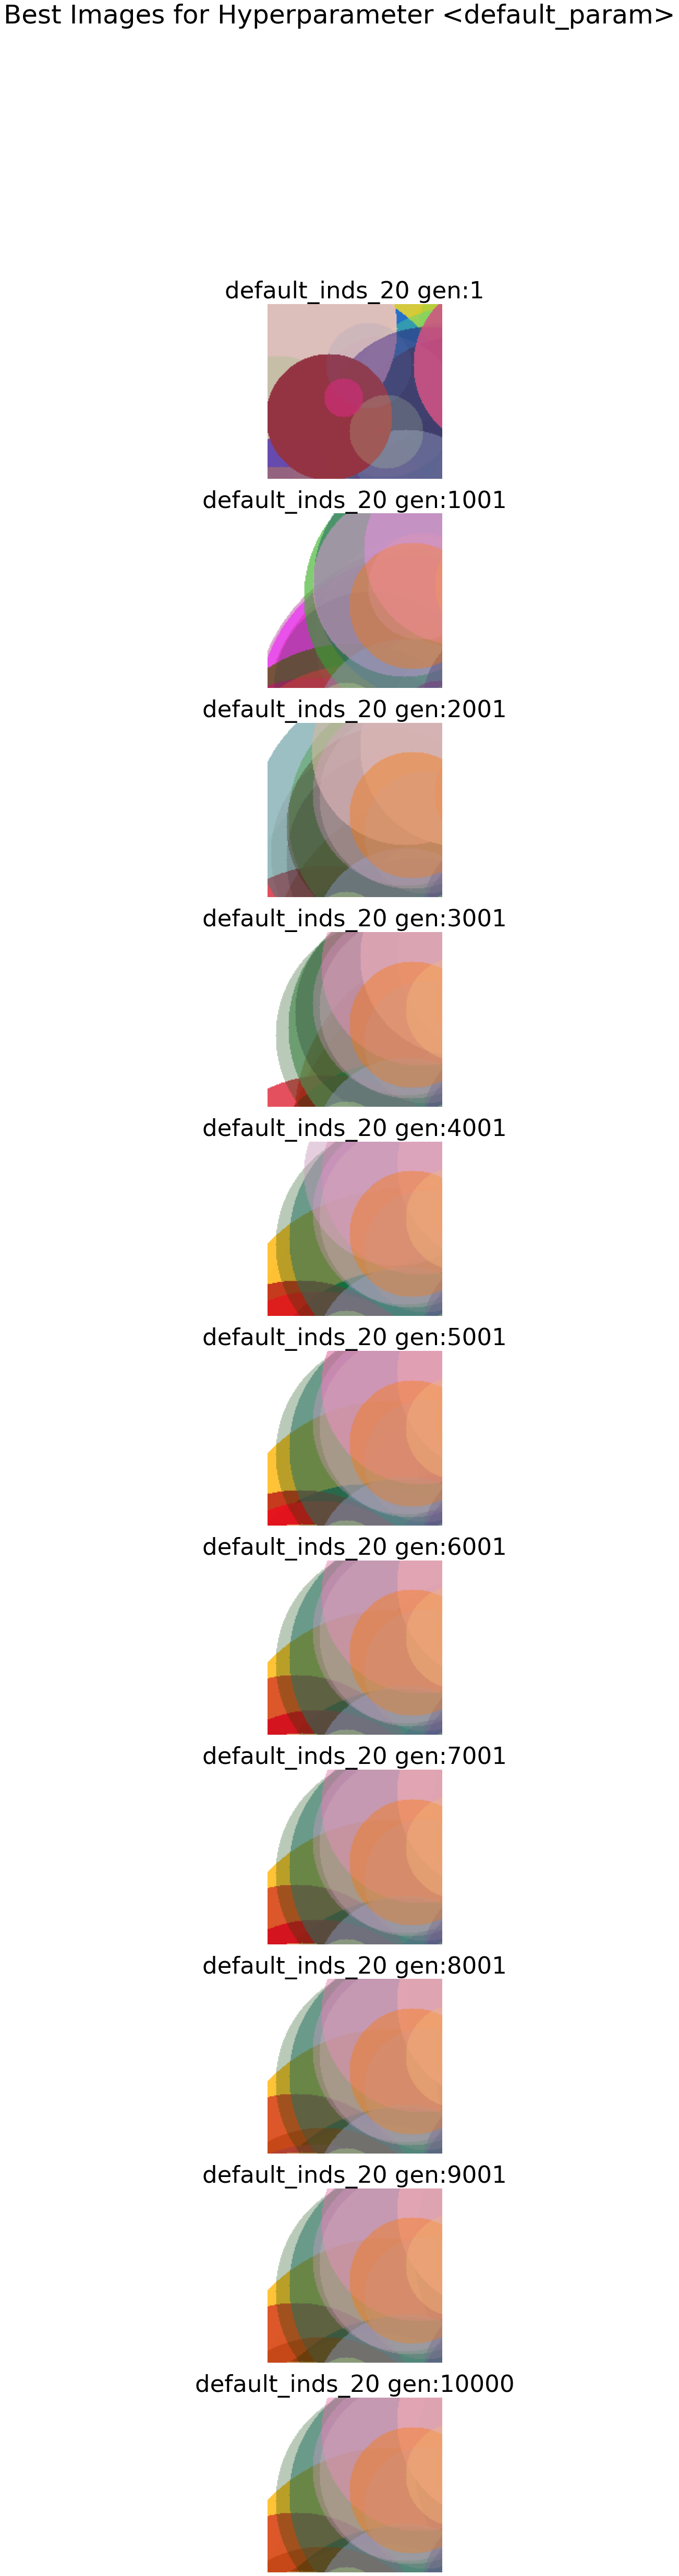

ax.ndim:  1


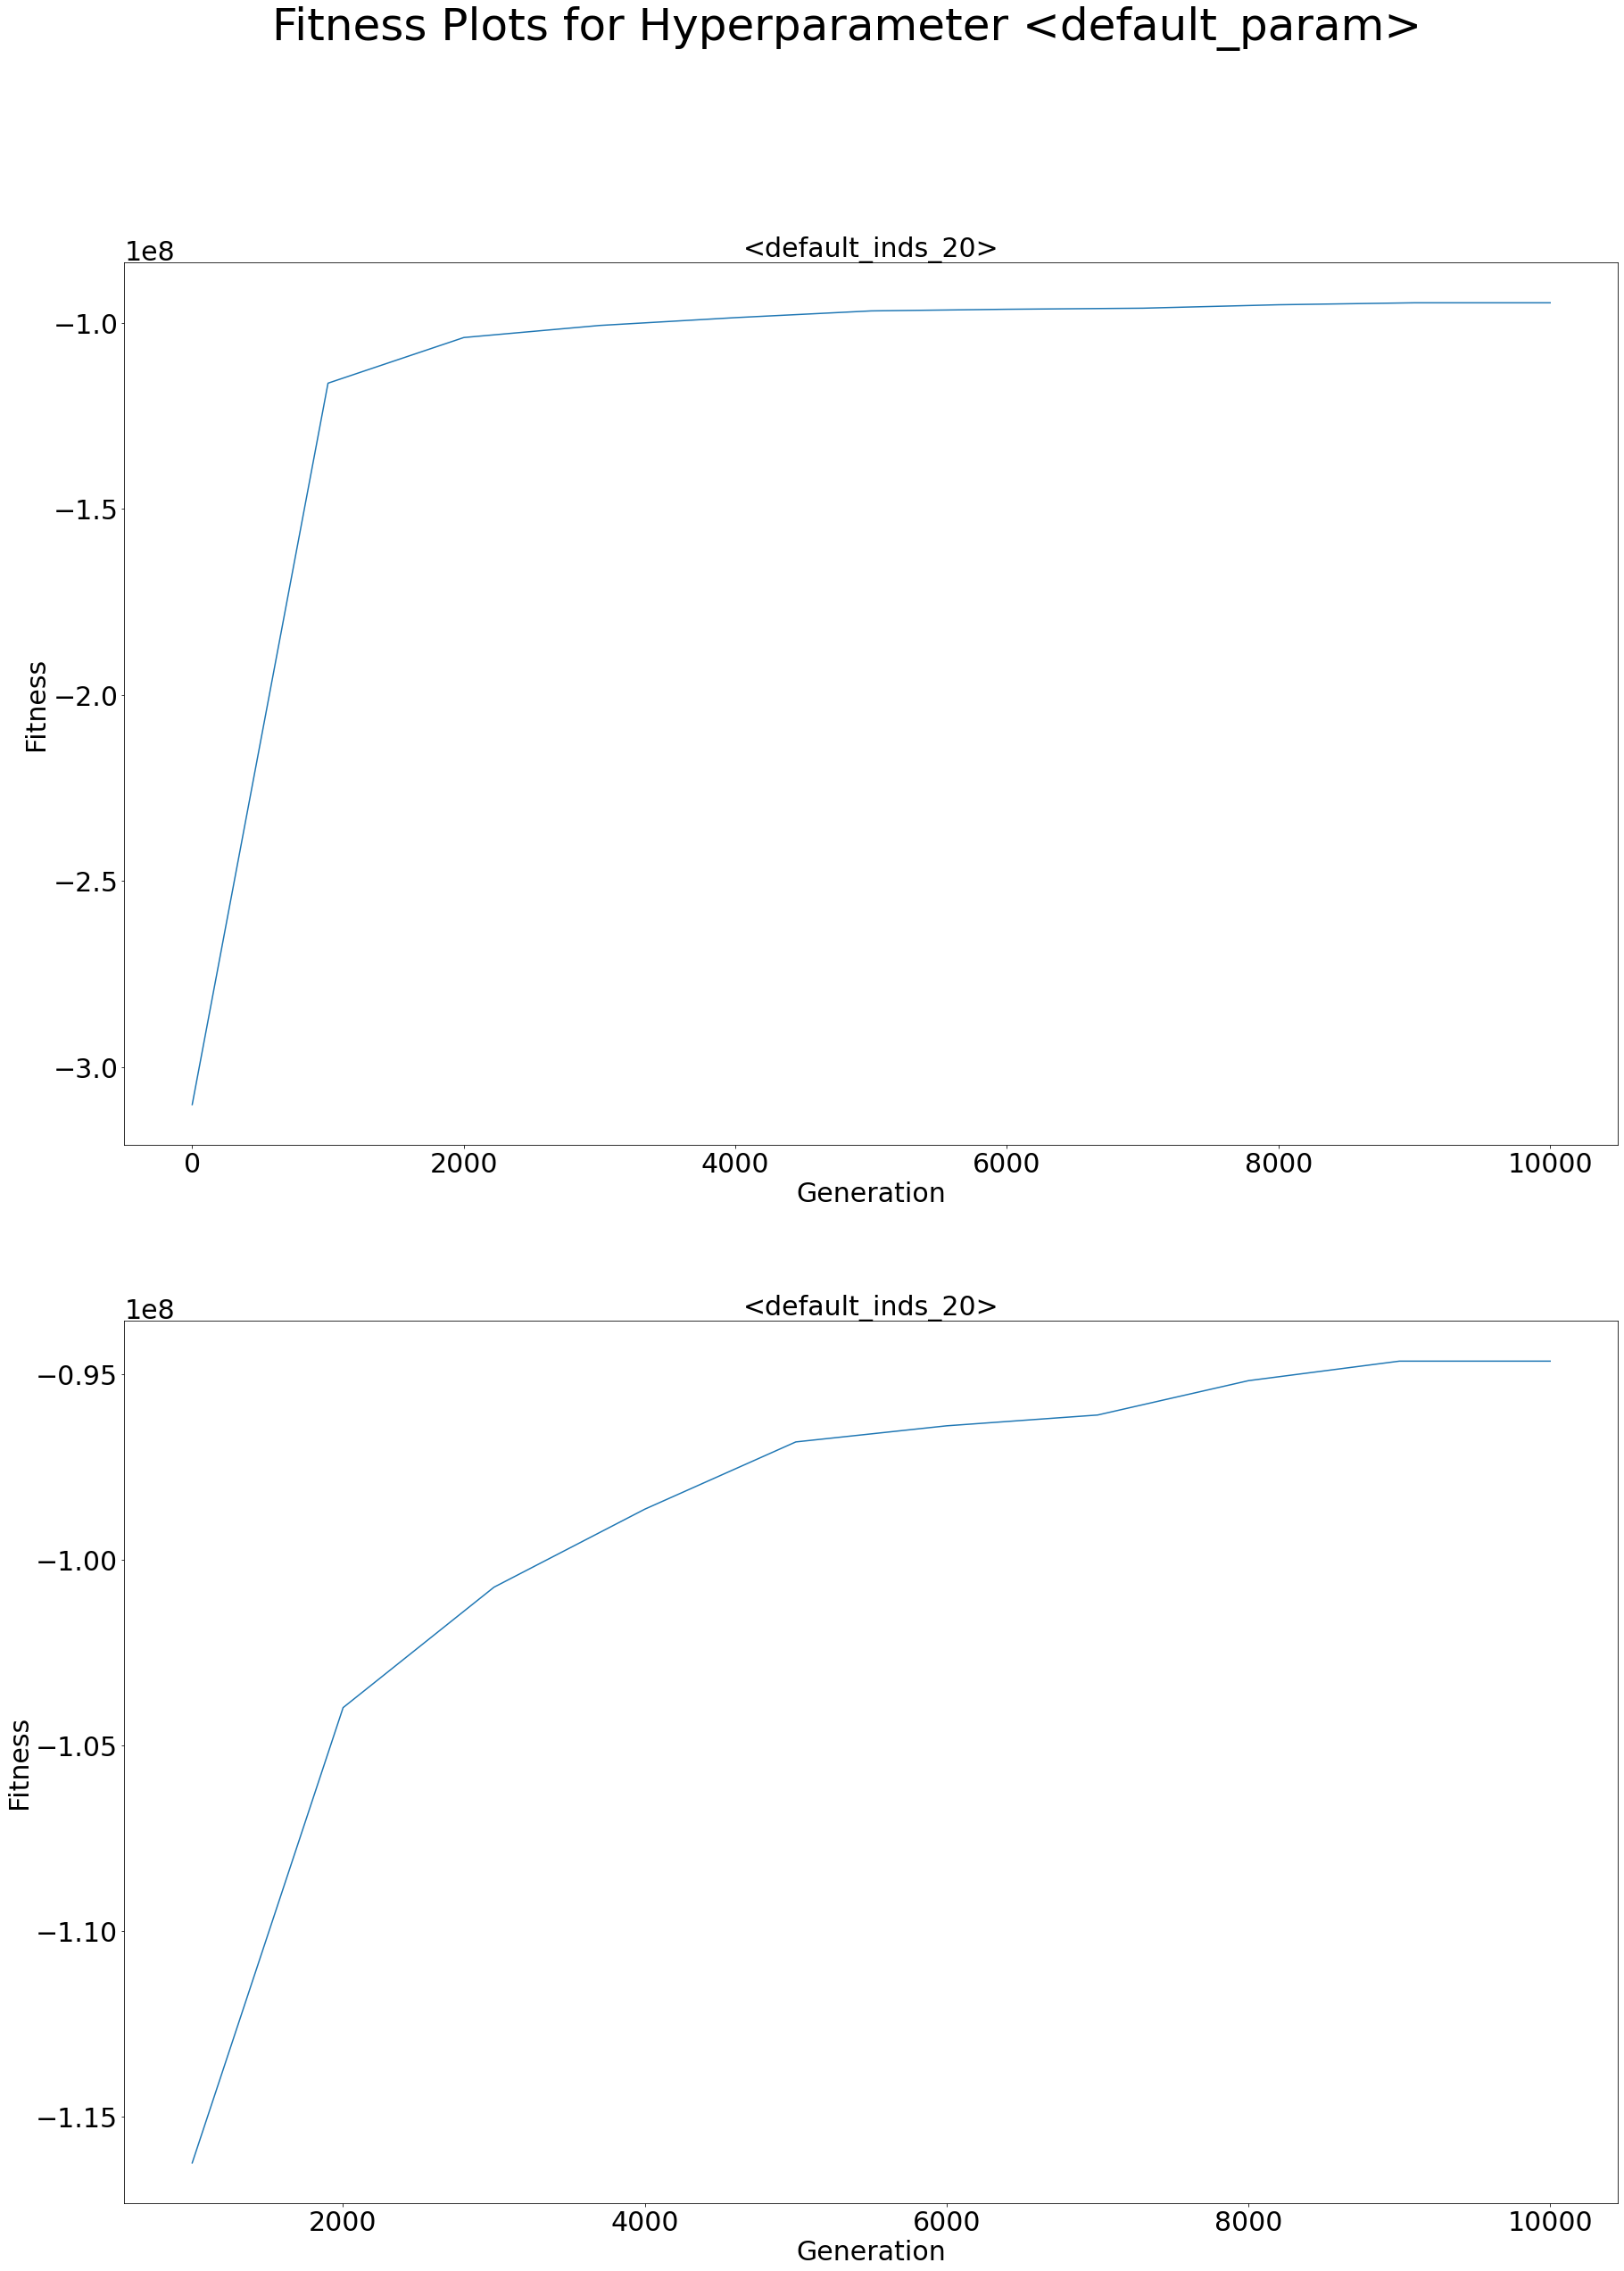

In [ ]:
# get default experimetal results from saved files and visualize them
default_param_images = get_all_images(["num_inds/default_inds_20"])
plot_images(default_param_images, "default_param", save_dir=SAVE_DIR + 'default_images')
plot_fitnesses(default_param_images, "default_param", save_dir=SAVE_DIR + 'default_fitness')

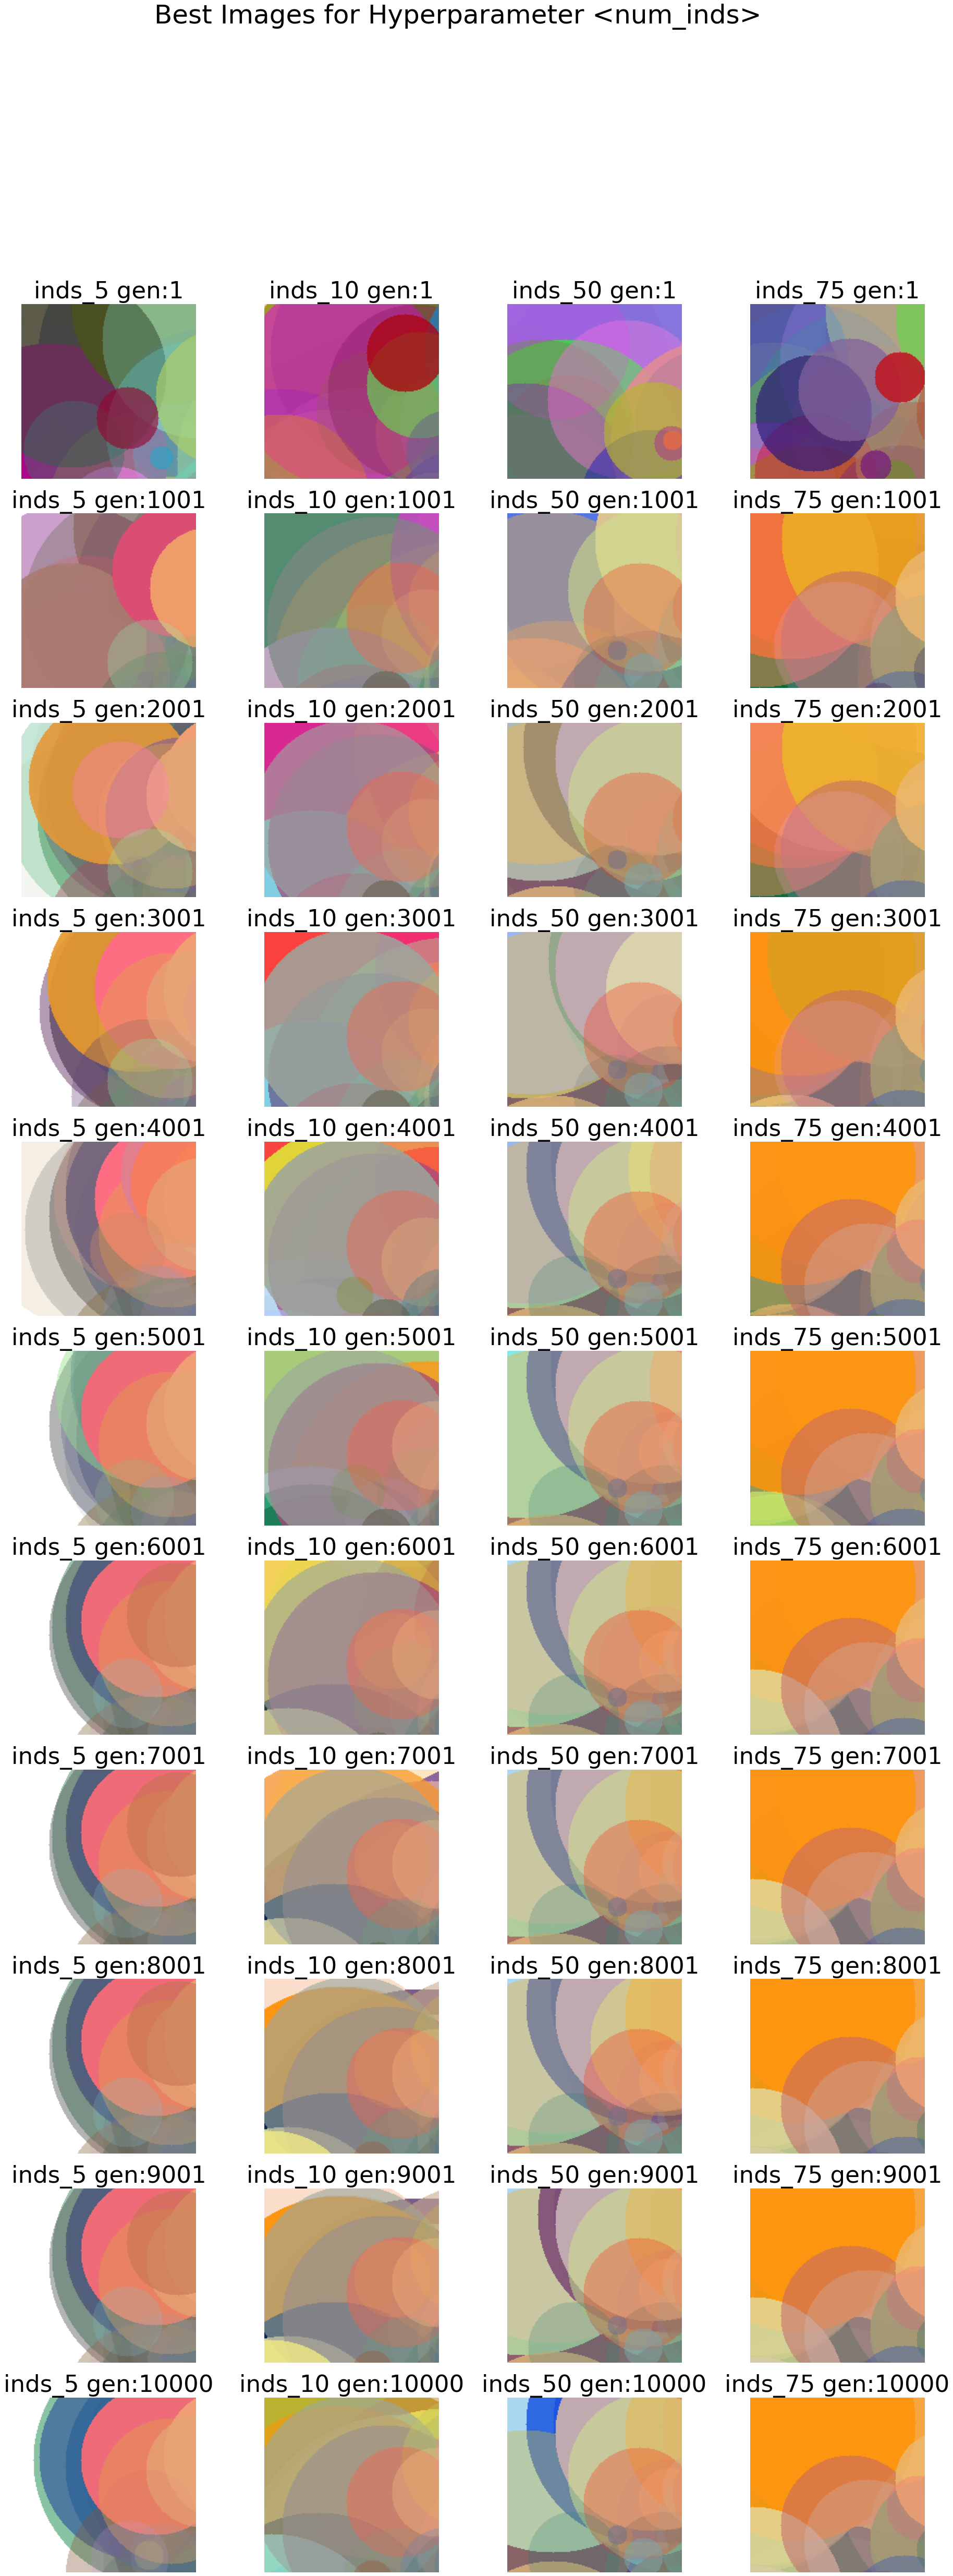

ax.ndim:  2


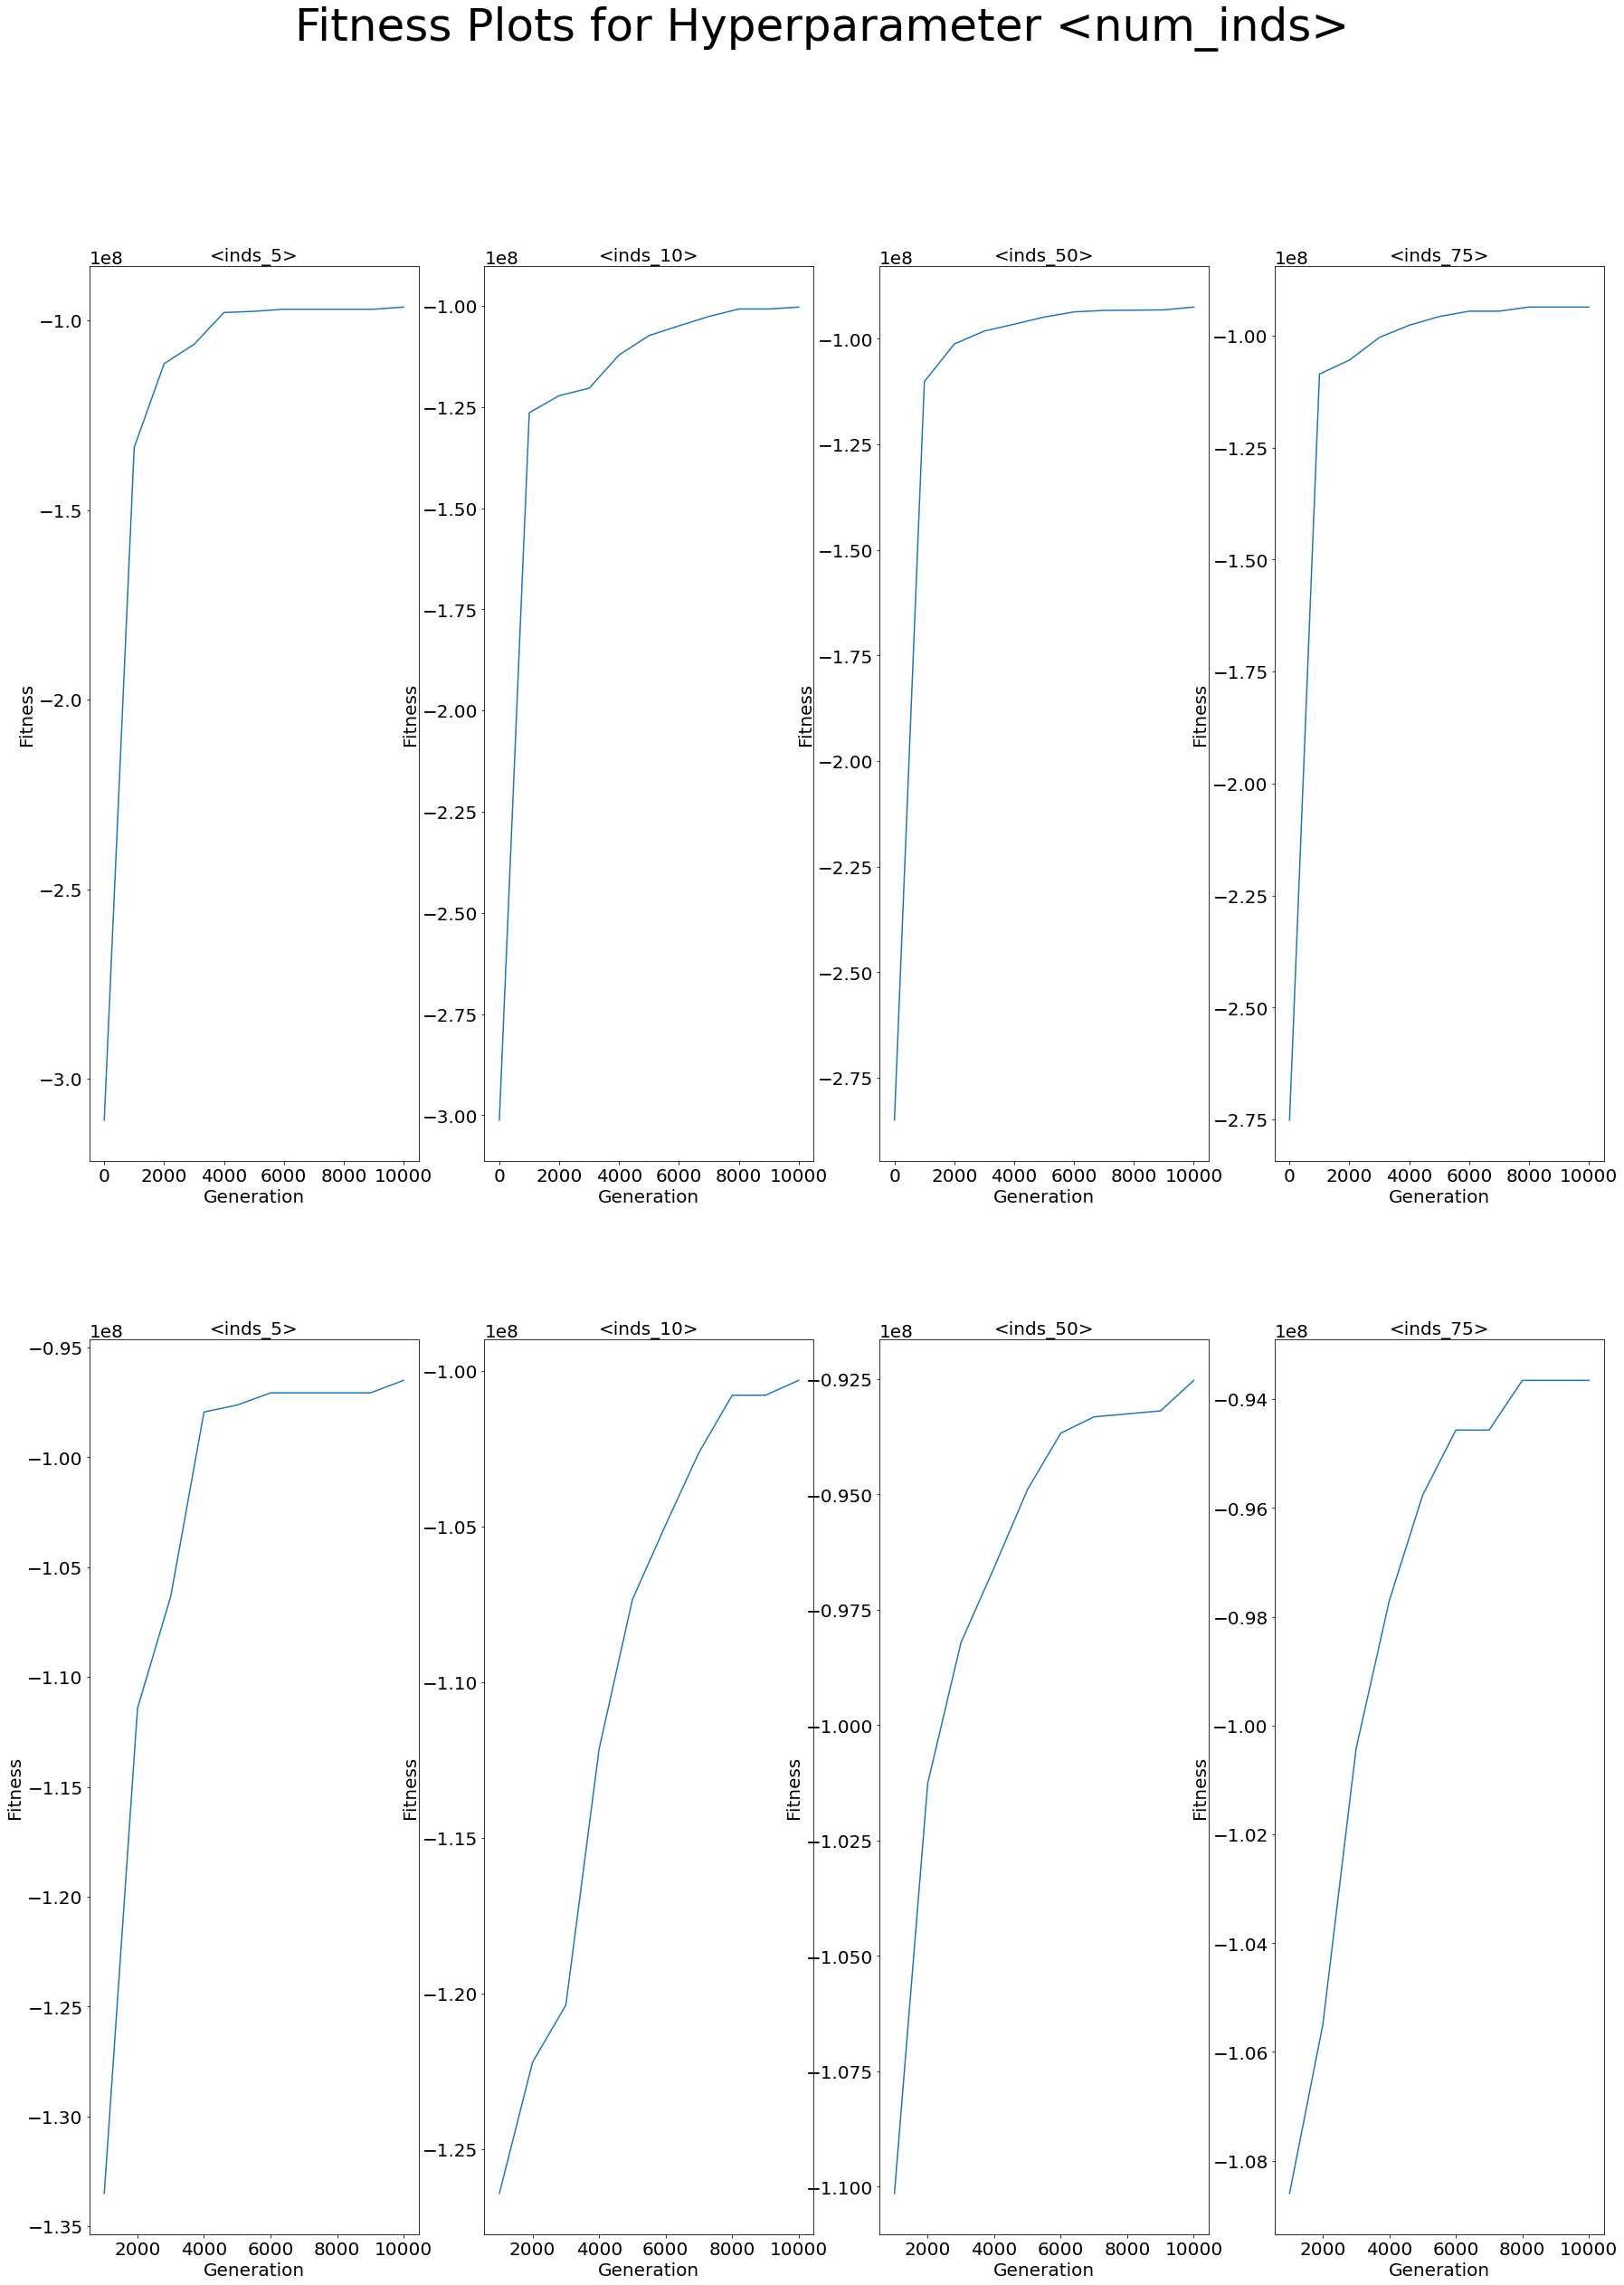

In [ ]:
# get num_inds experimetal results from saved files and visualize them
num_inds_images = get_all_images(["num_inds/inds_5", "num_inds/inds_10", "num_inds/inds_50", "num_inds/inds_75"])
plot_images(num_inds_images, "num_inds", save_dir=SAVE_DIR + 'num_inds_images')
plot_fitnesses(num_inds_images, "num_inds", save_dir=SAVE_DIR + 'num_inds_fitness')

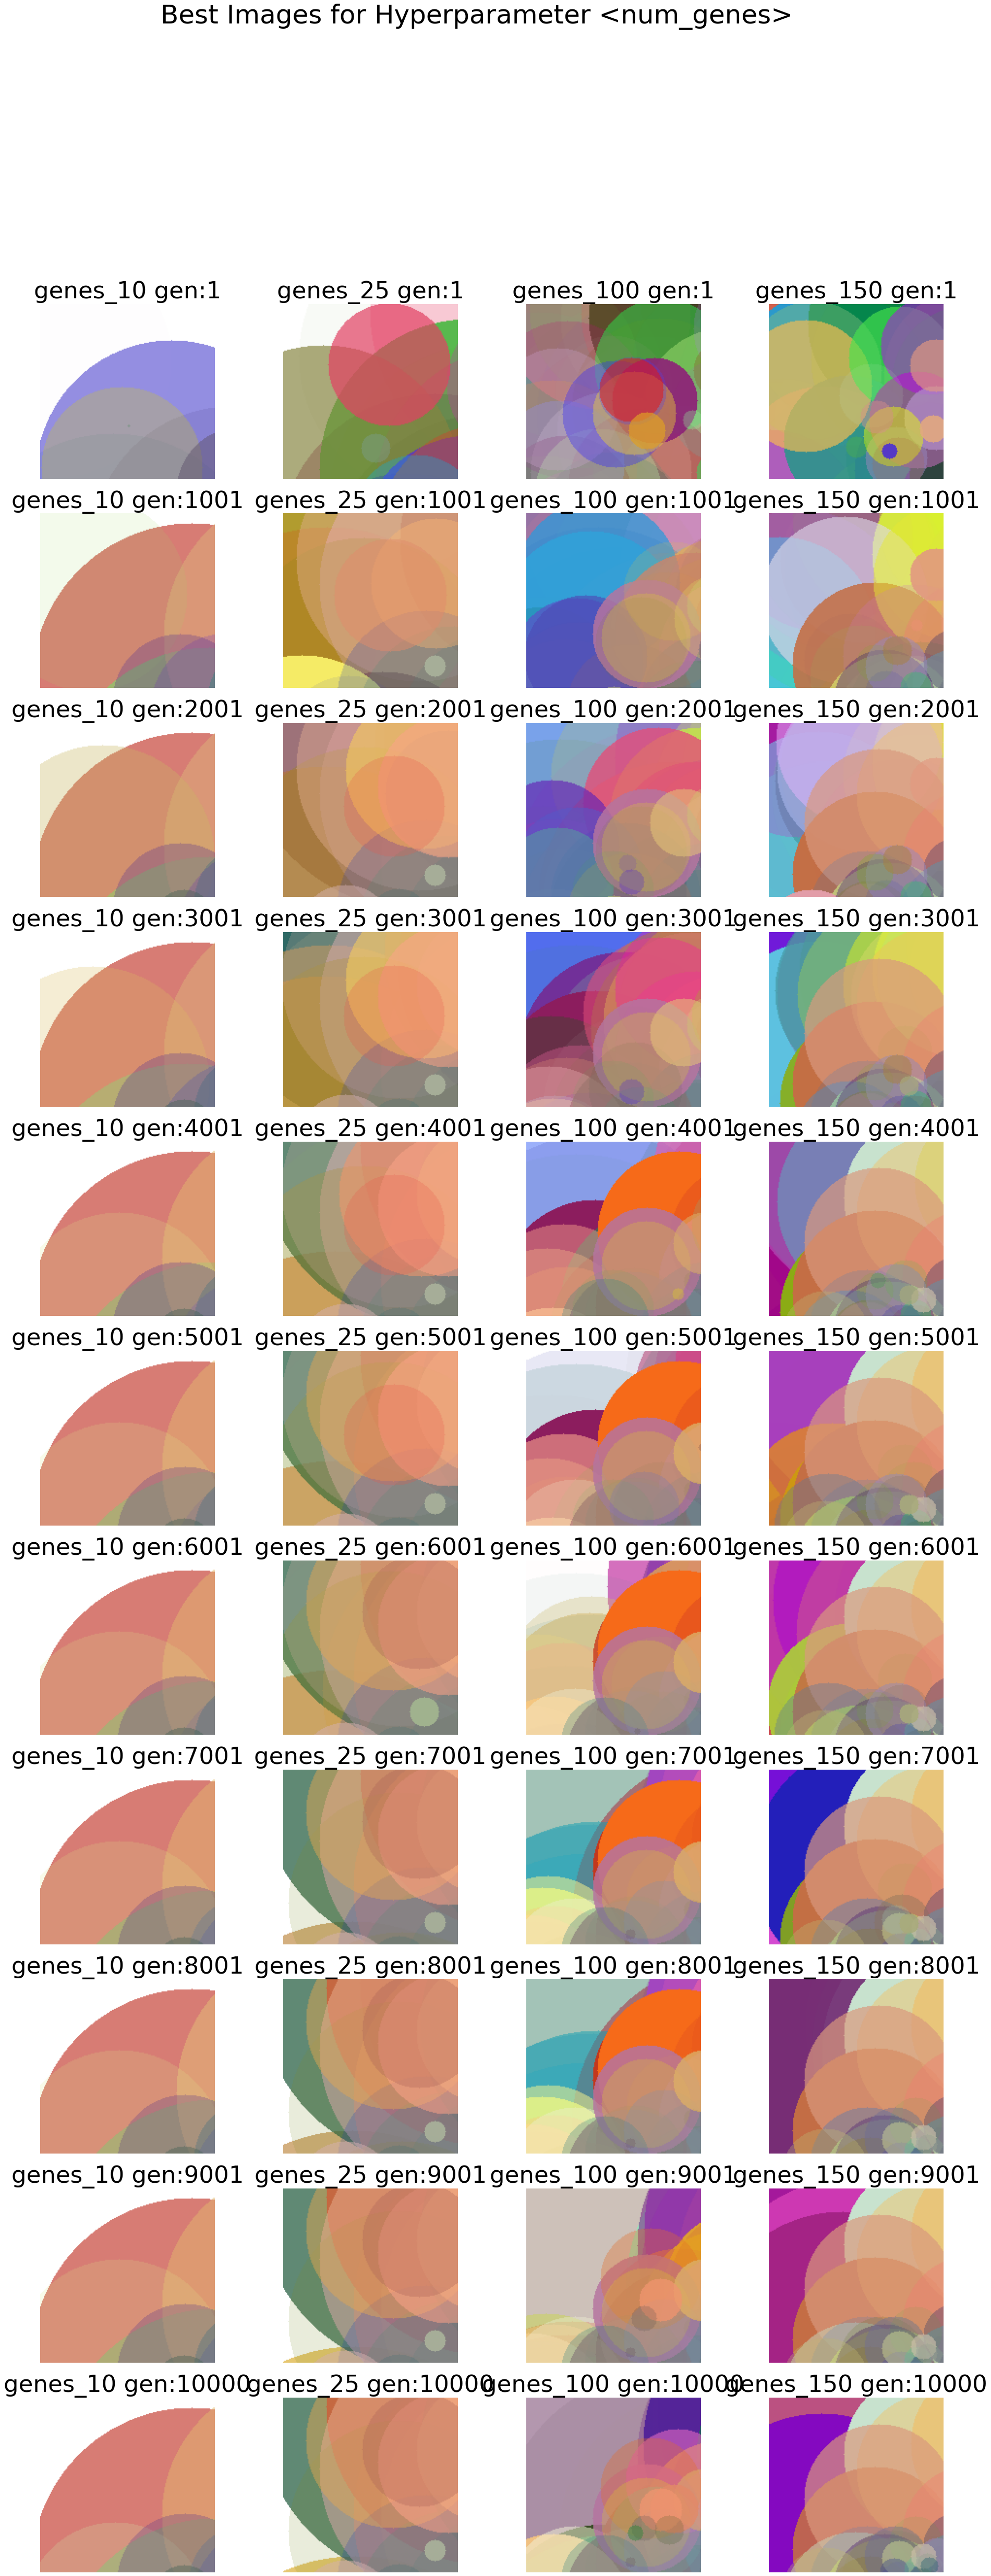

ax.ndim:  2


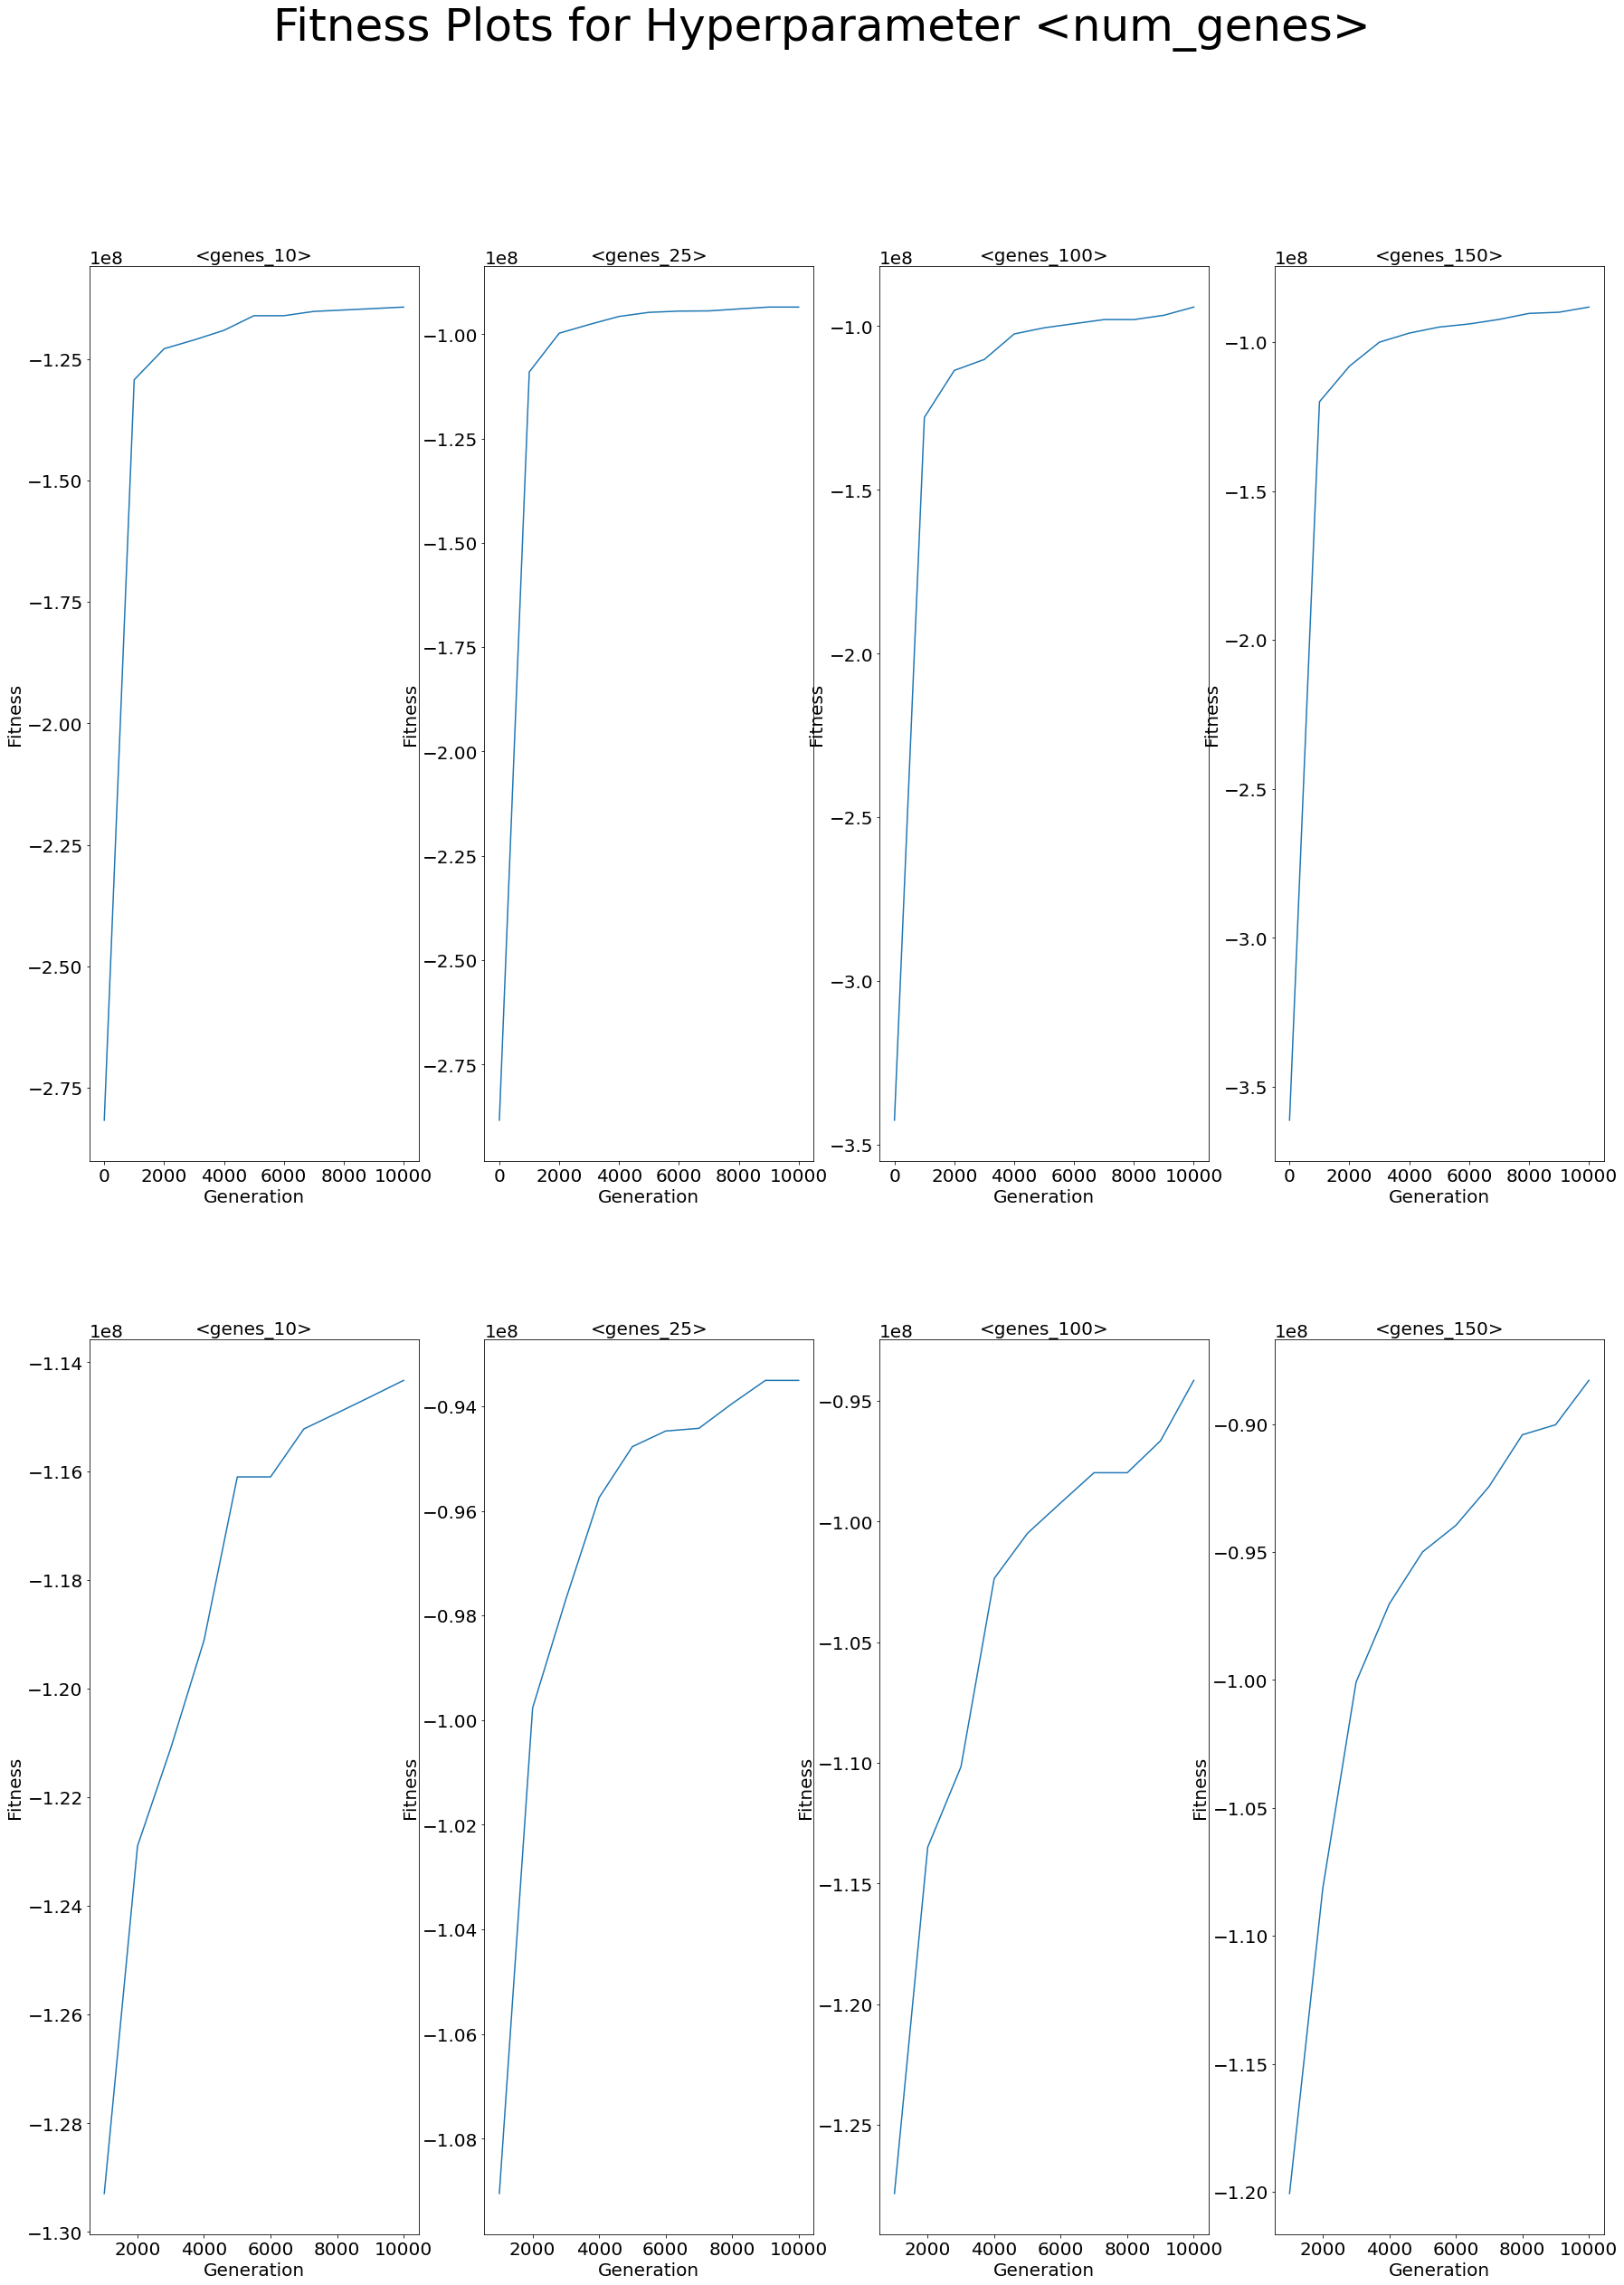

In [ ]:
# get num_genes experimetal results from saved files and visualize them
num_genes_images = get_all_images(["num_genes/genes_10", "num_genes/genes_25", "num_genes/genes_100", "num_genes/genes_150"])
plot_images(num_genes_images, "num_genes", save_dir=SAVE_DIR + 'num_genes_images')
plot_fitnesses(num_genes_images, "num_genes", save_dir=SAVE_DIR + 'num_genes_fitness')


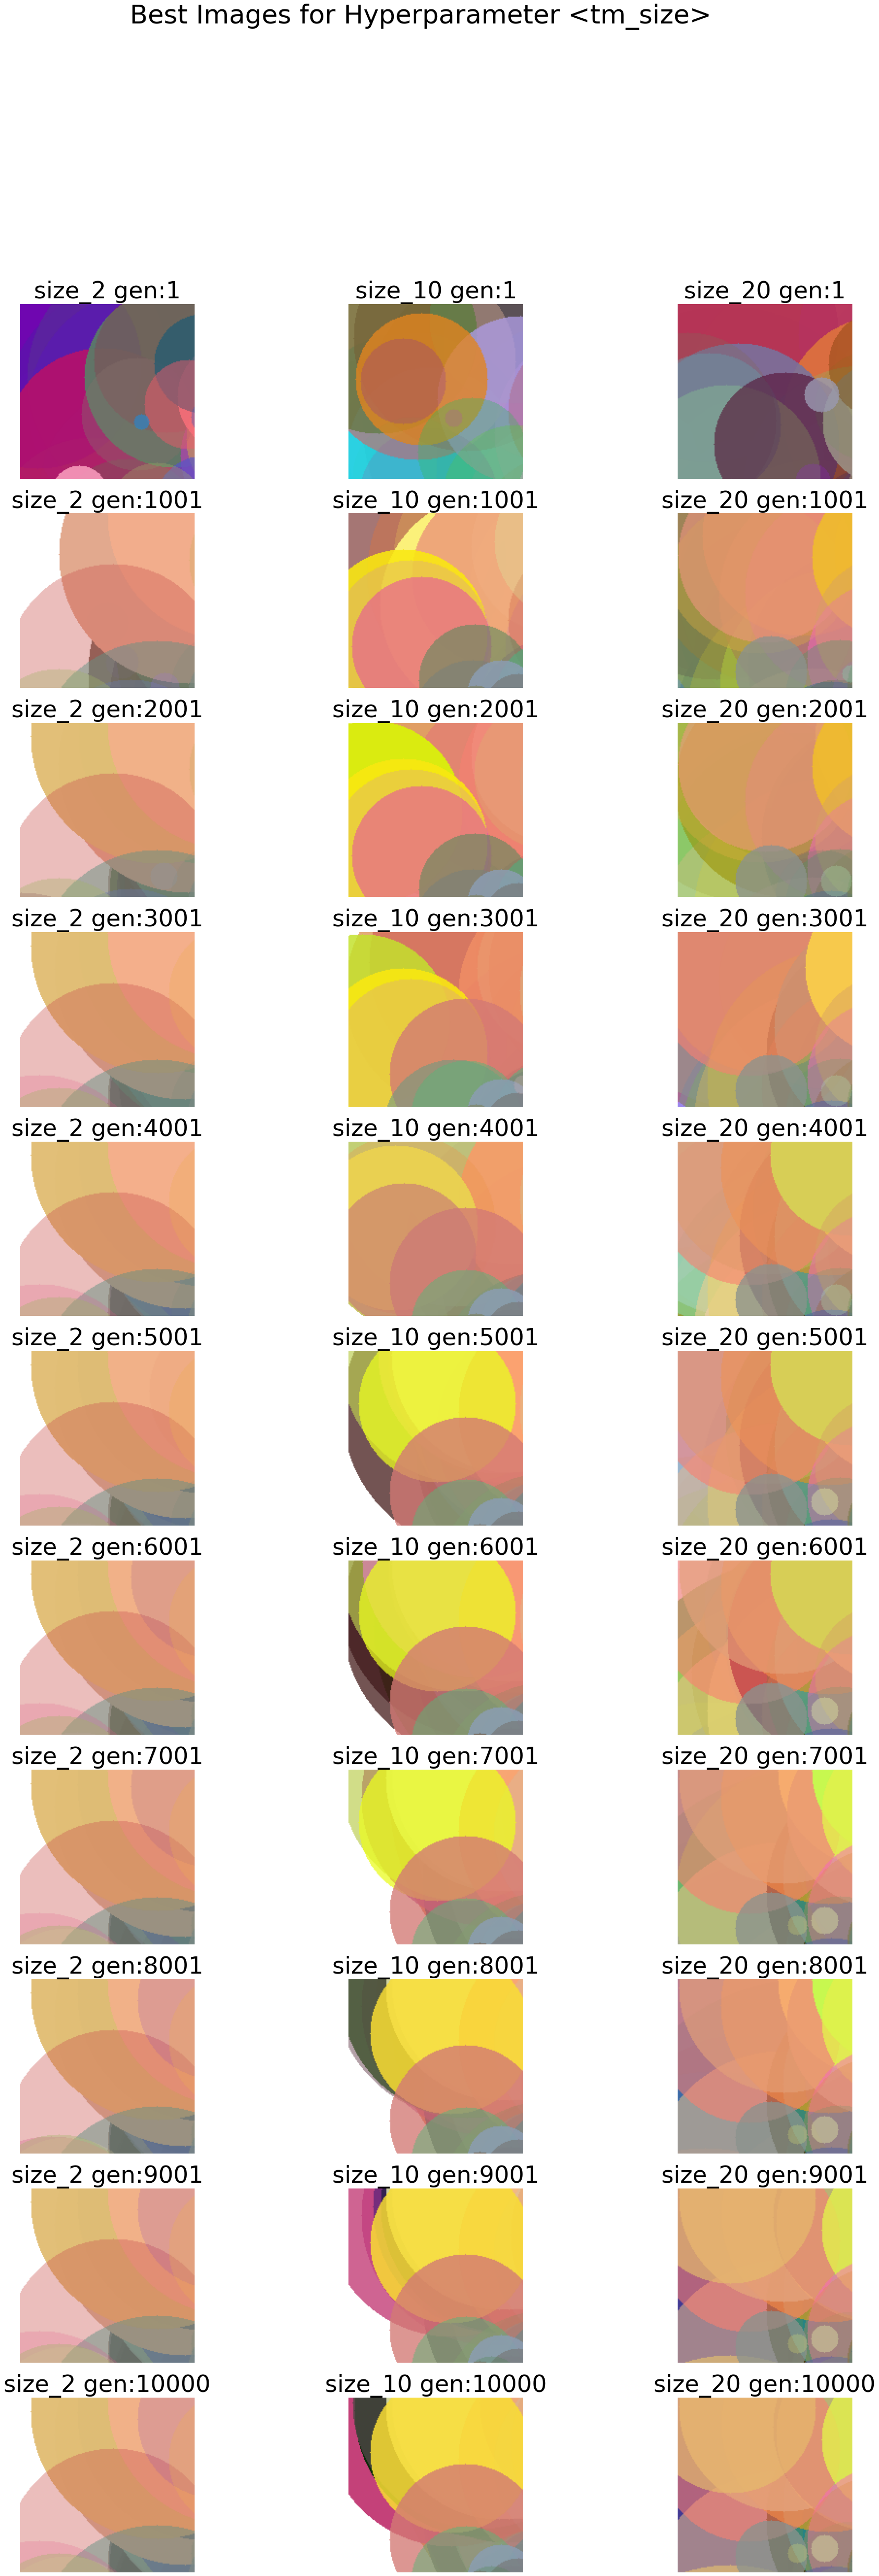

ax.ndim:  2


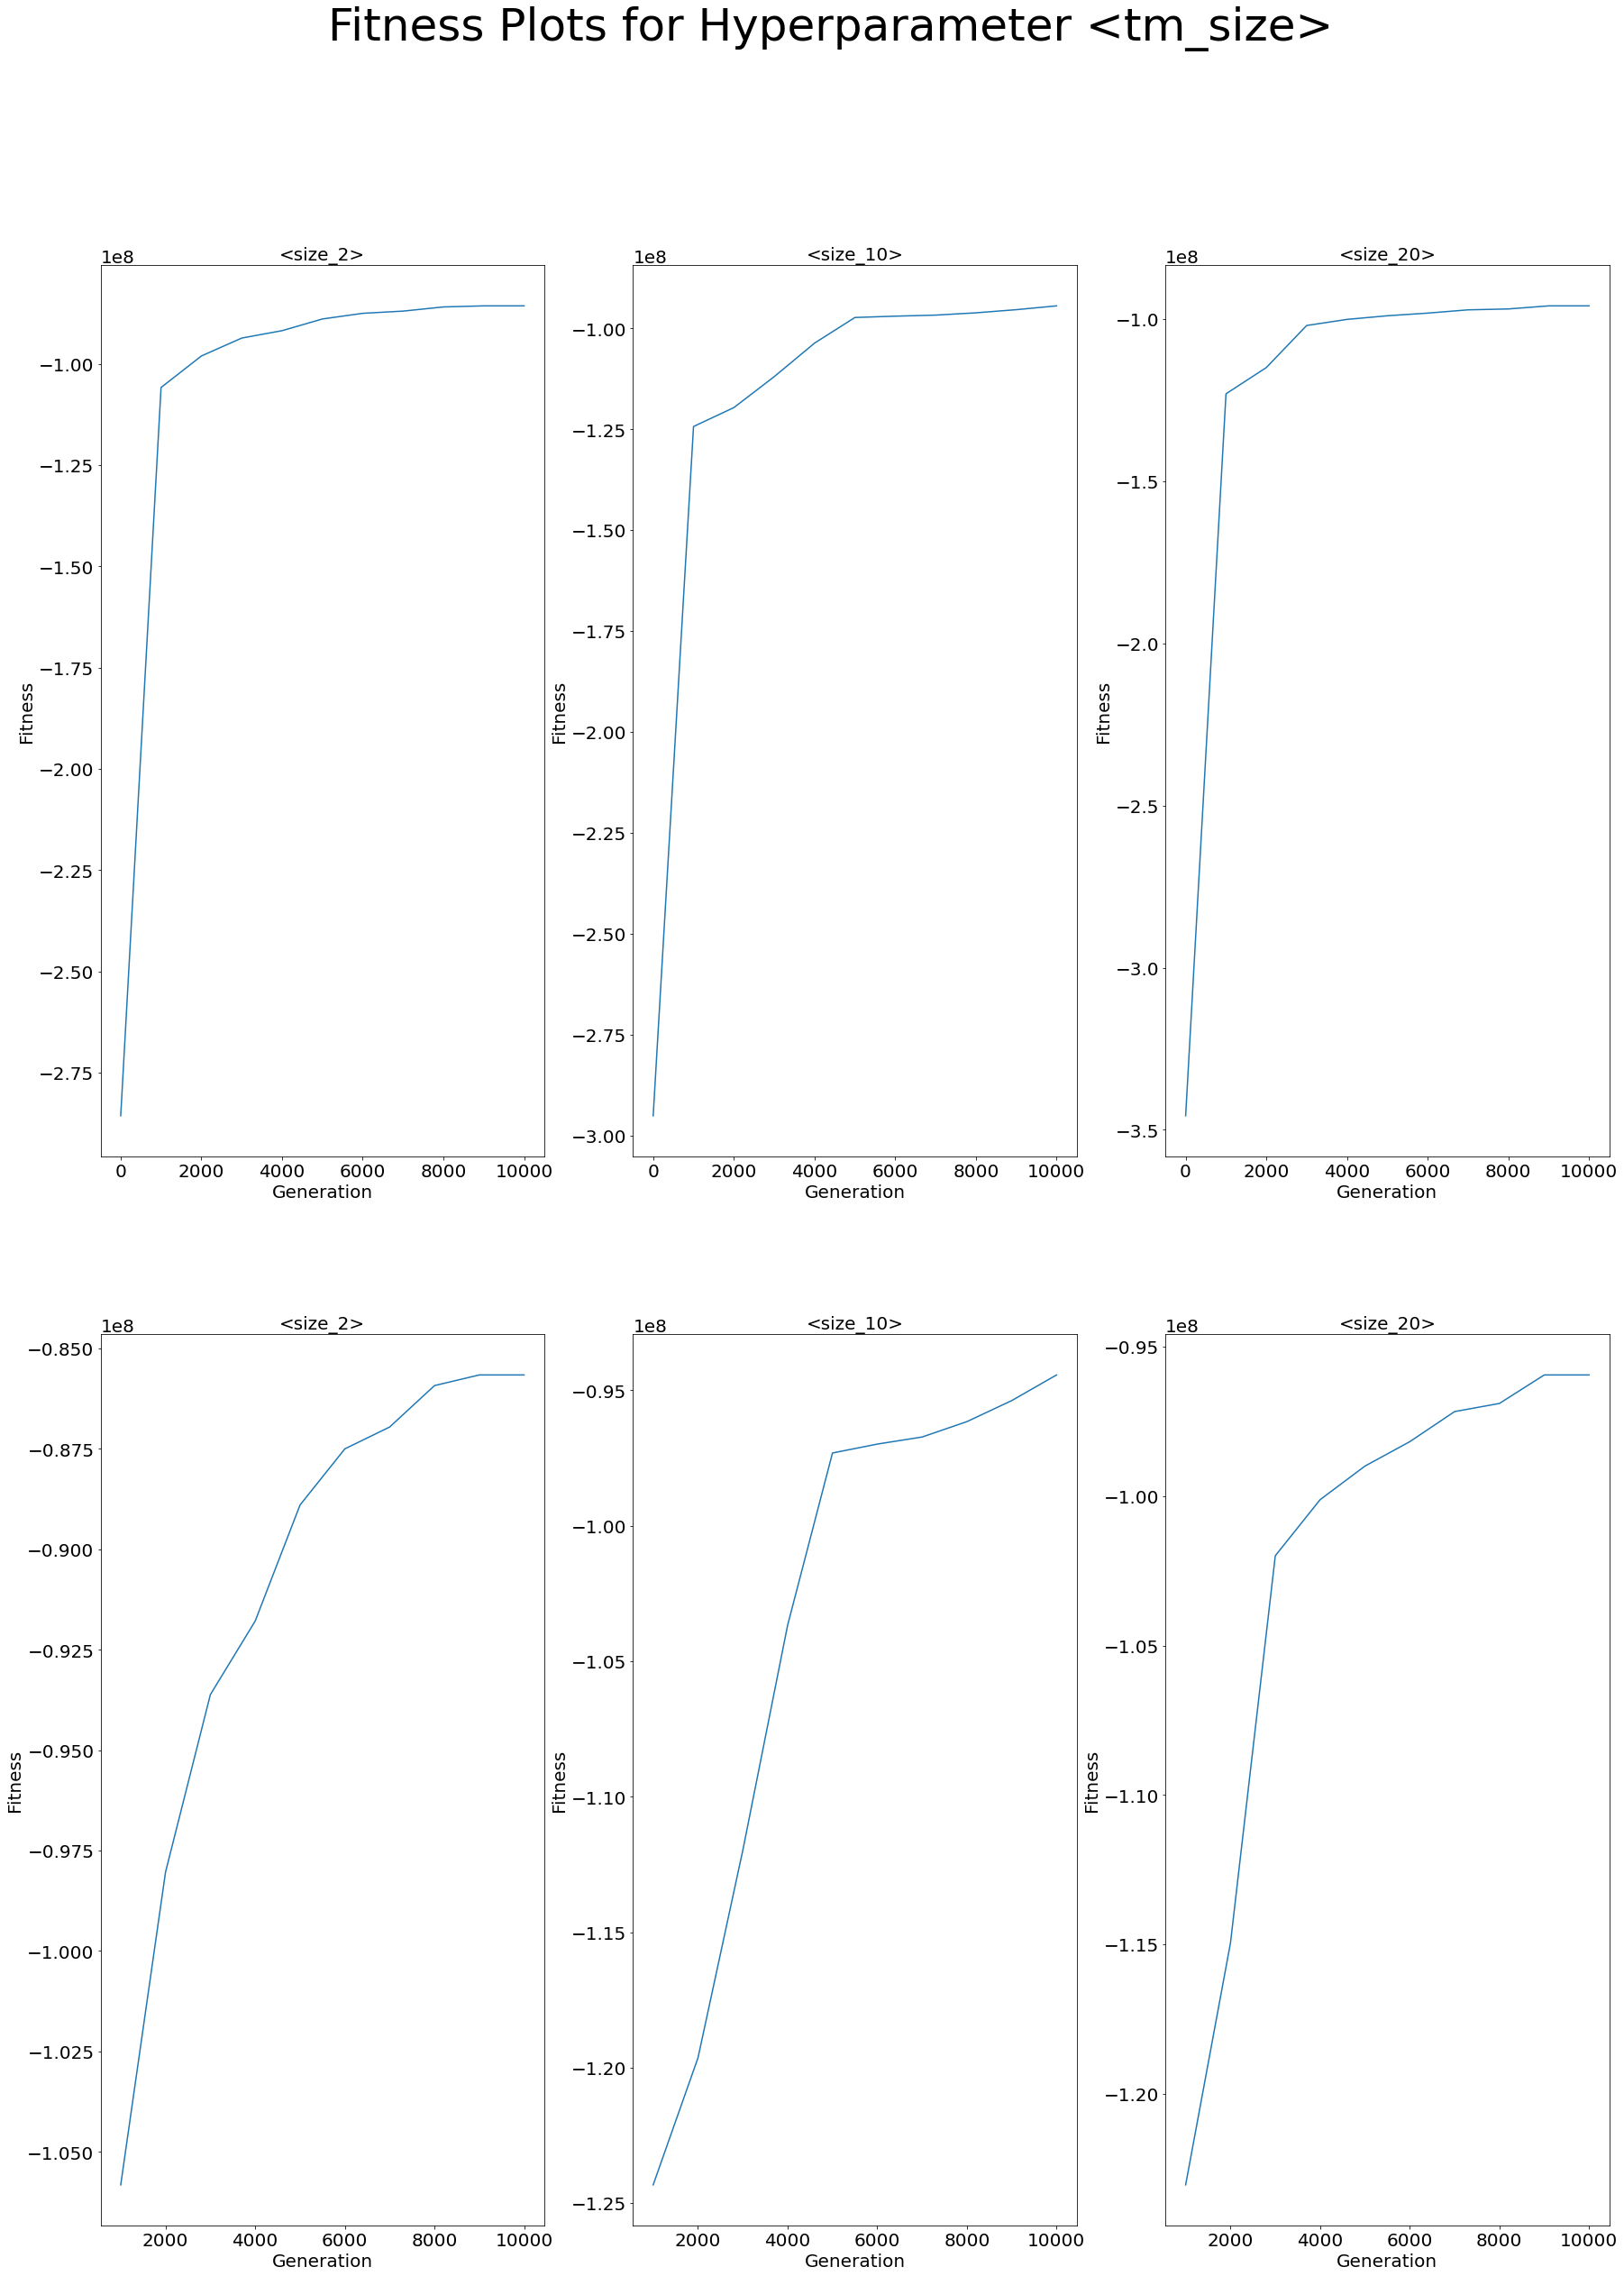

In [ ]:
# get tm_size experimetal results from saved files and visualize them
tm_size_images = get_all_images(["tm_size/size_2", "tm_size/size_10", "tm_size/size_20"])
plot_images(tm_size_images, "tm_size", save_dir=SAVE_DIR + 'tm_size_images')
plot_fitnesses(tm_size_images, "tm_size", save_dir=SAVE_DIR + 'tm_size_fitness')

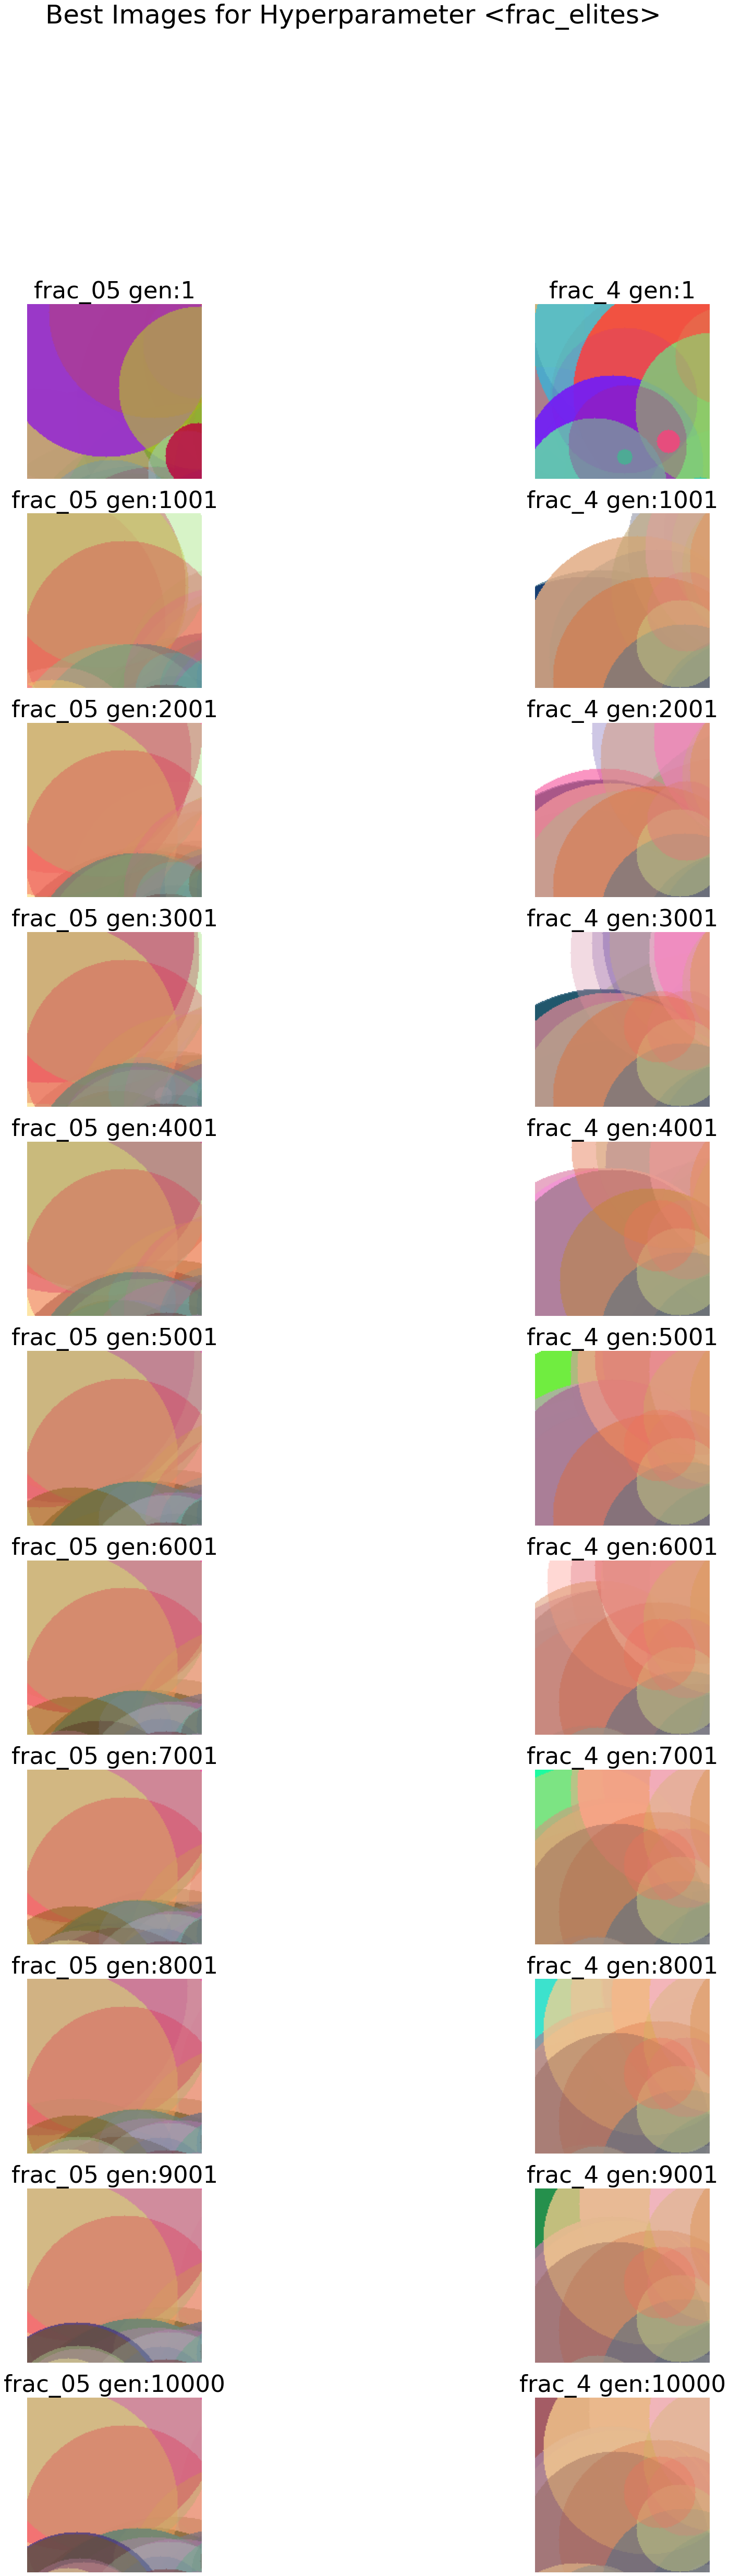

ax.ndim:  2


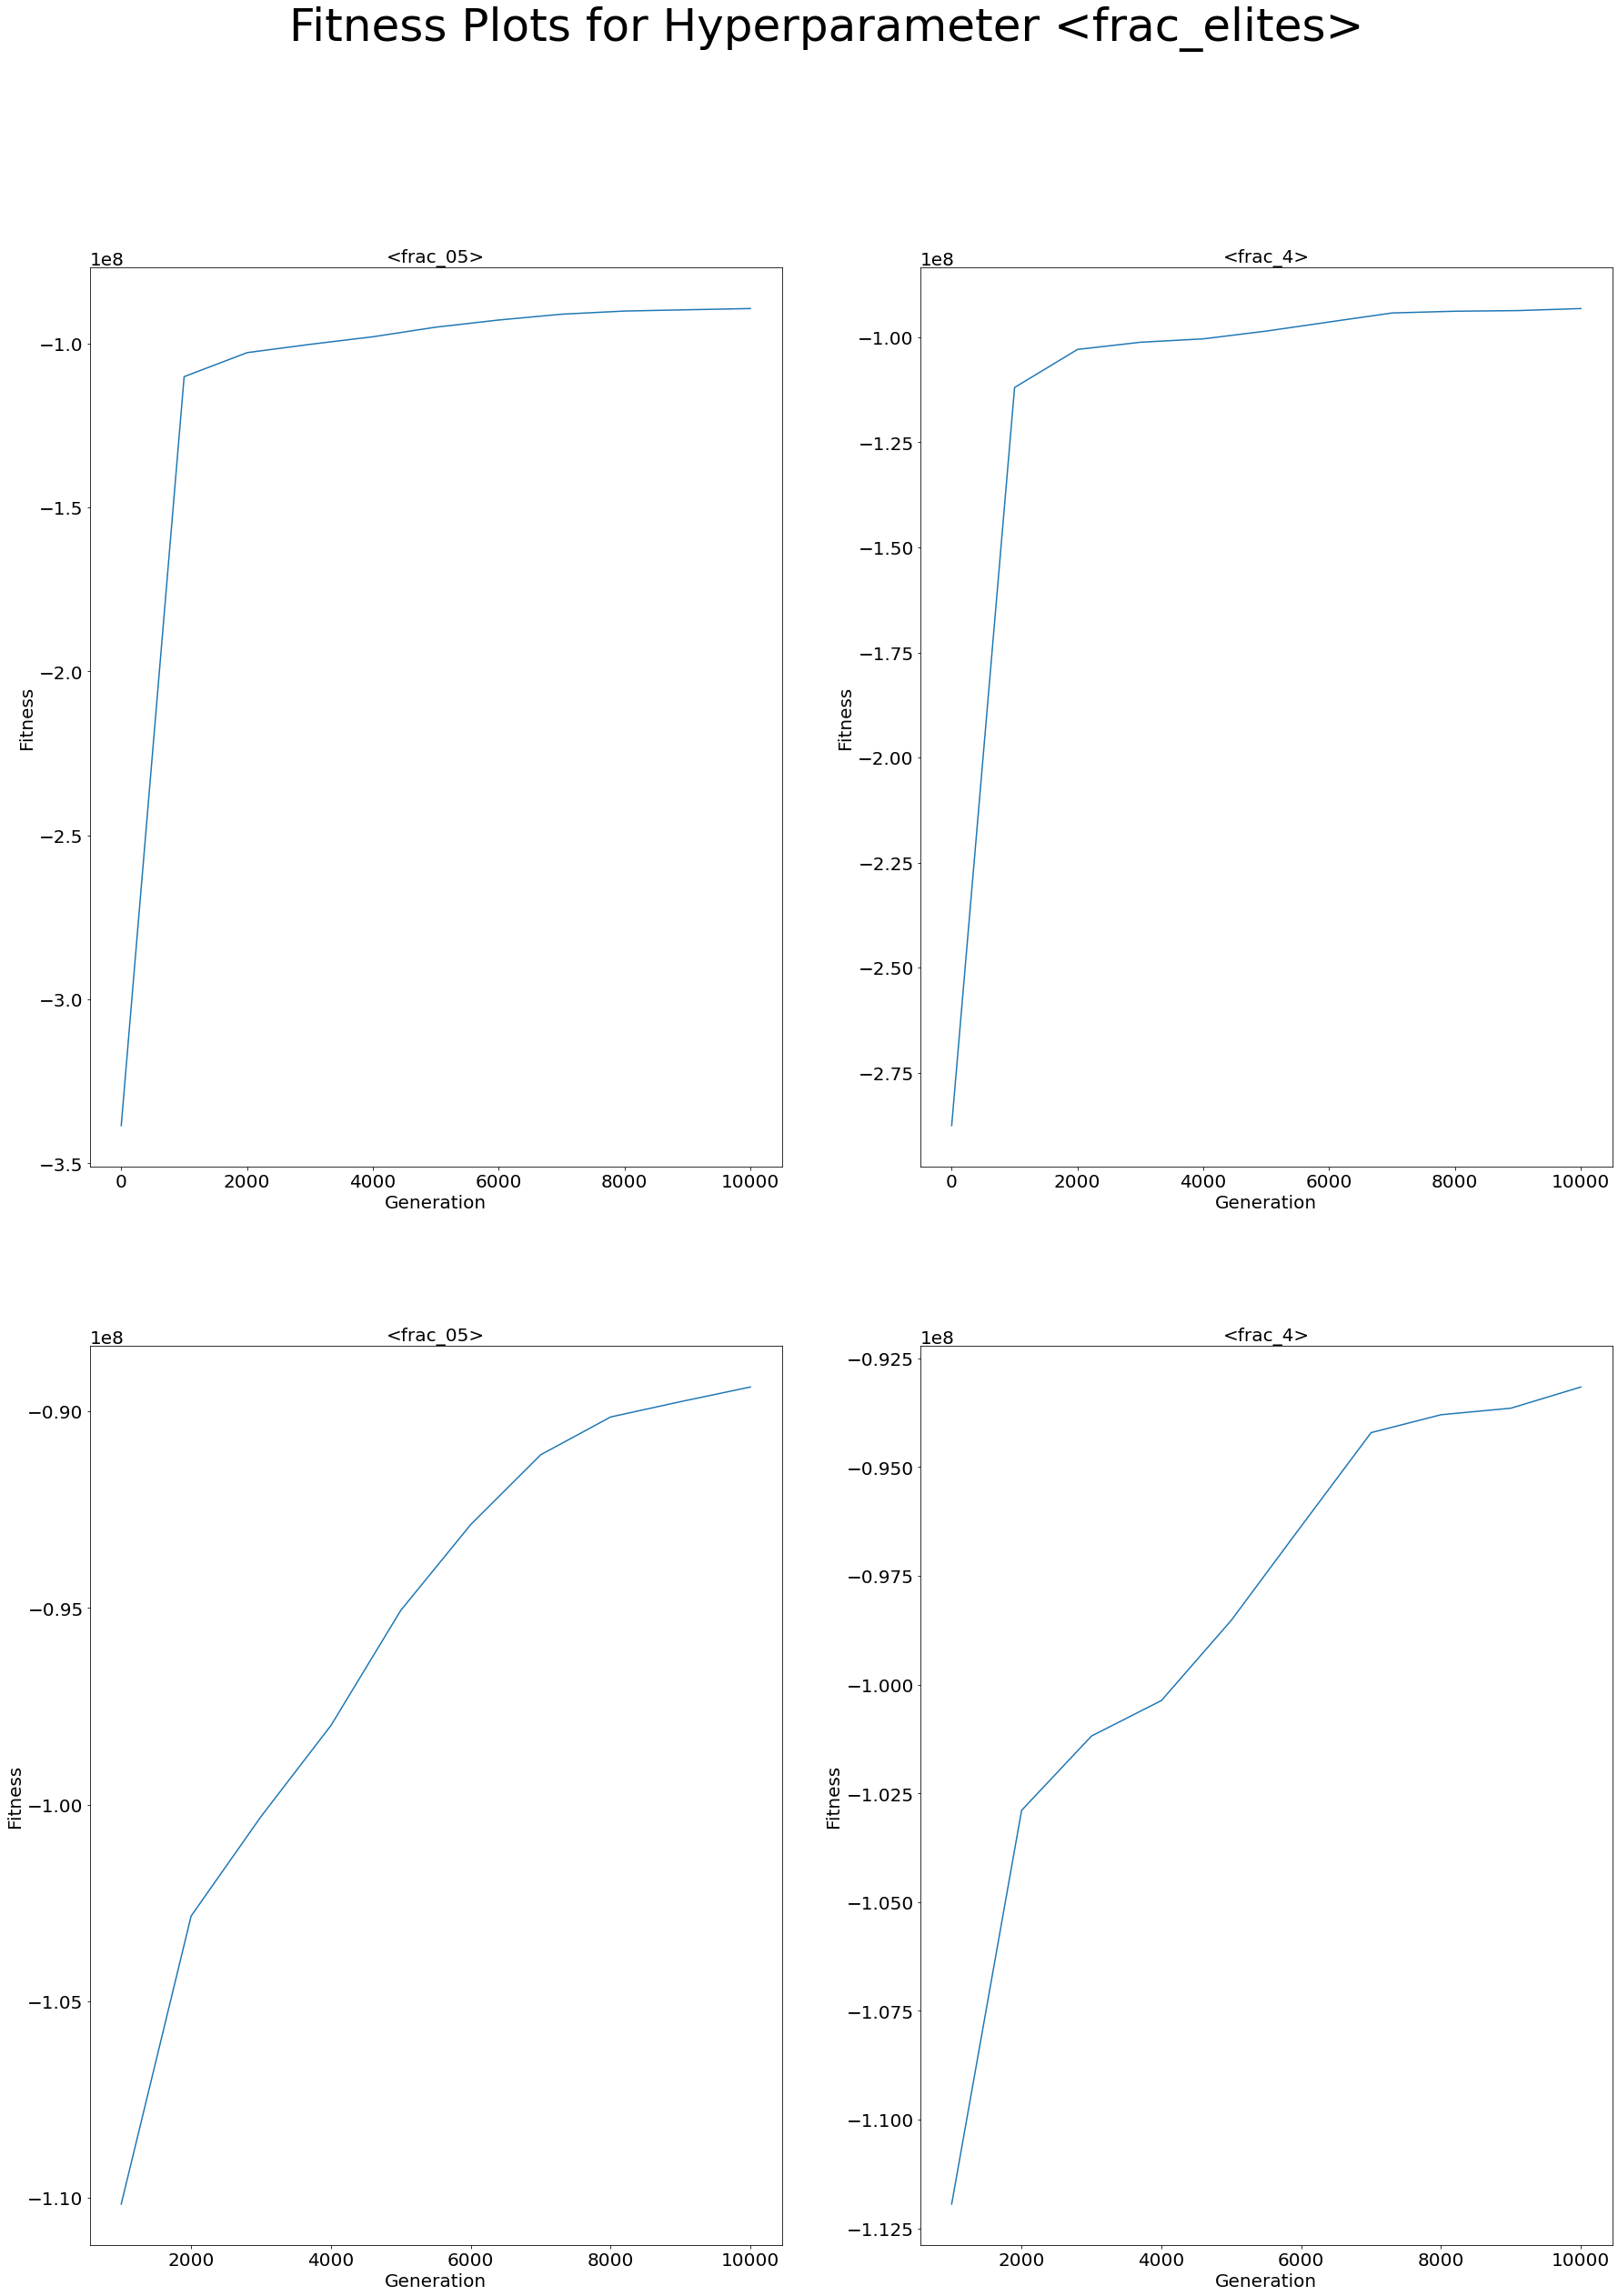

In [ ]:
# get frac_elites experimetal results from saved files and visualize them
frac_elites_images = get_all_images(["frac_elites/frac_05", "frac_elites/frac_4"])
plot_images(frac_elites_images, "frac_elites", save_dir=SAVE_DIR + 'frac_elites_images')
plot_fitnesses(frac_elites_images, "frac_elites", save_dir=SAVE_DIR + 'frac_elites_fitness')

KeyboardInterrupt: ignored

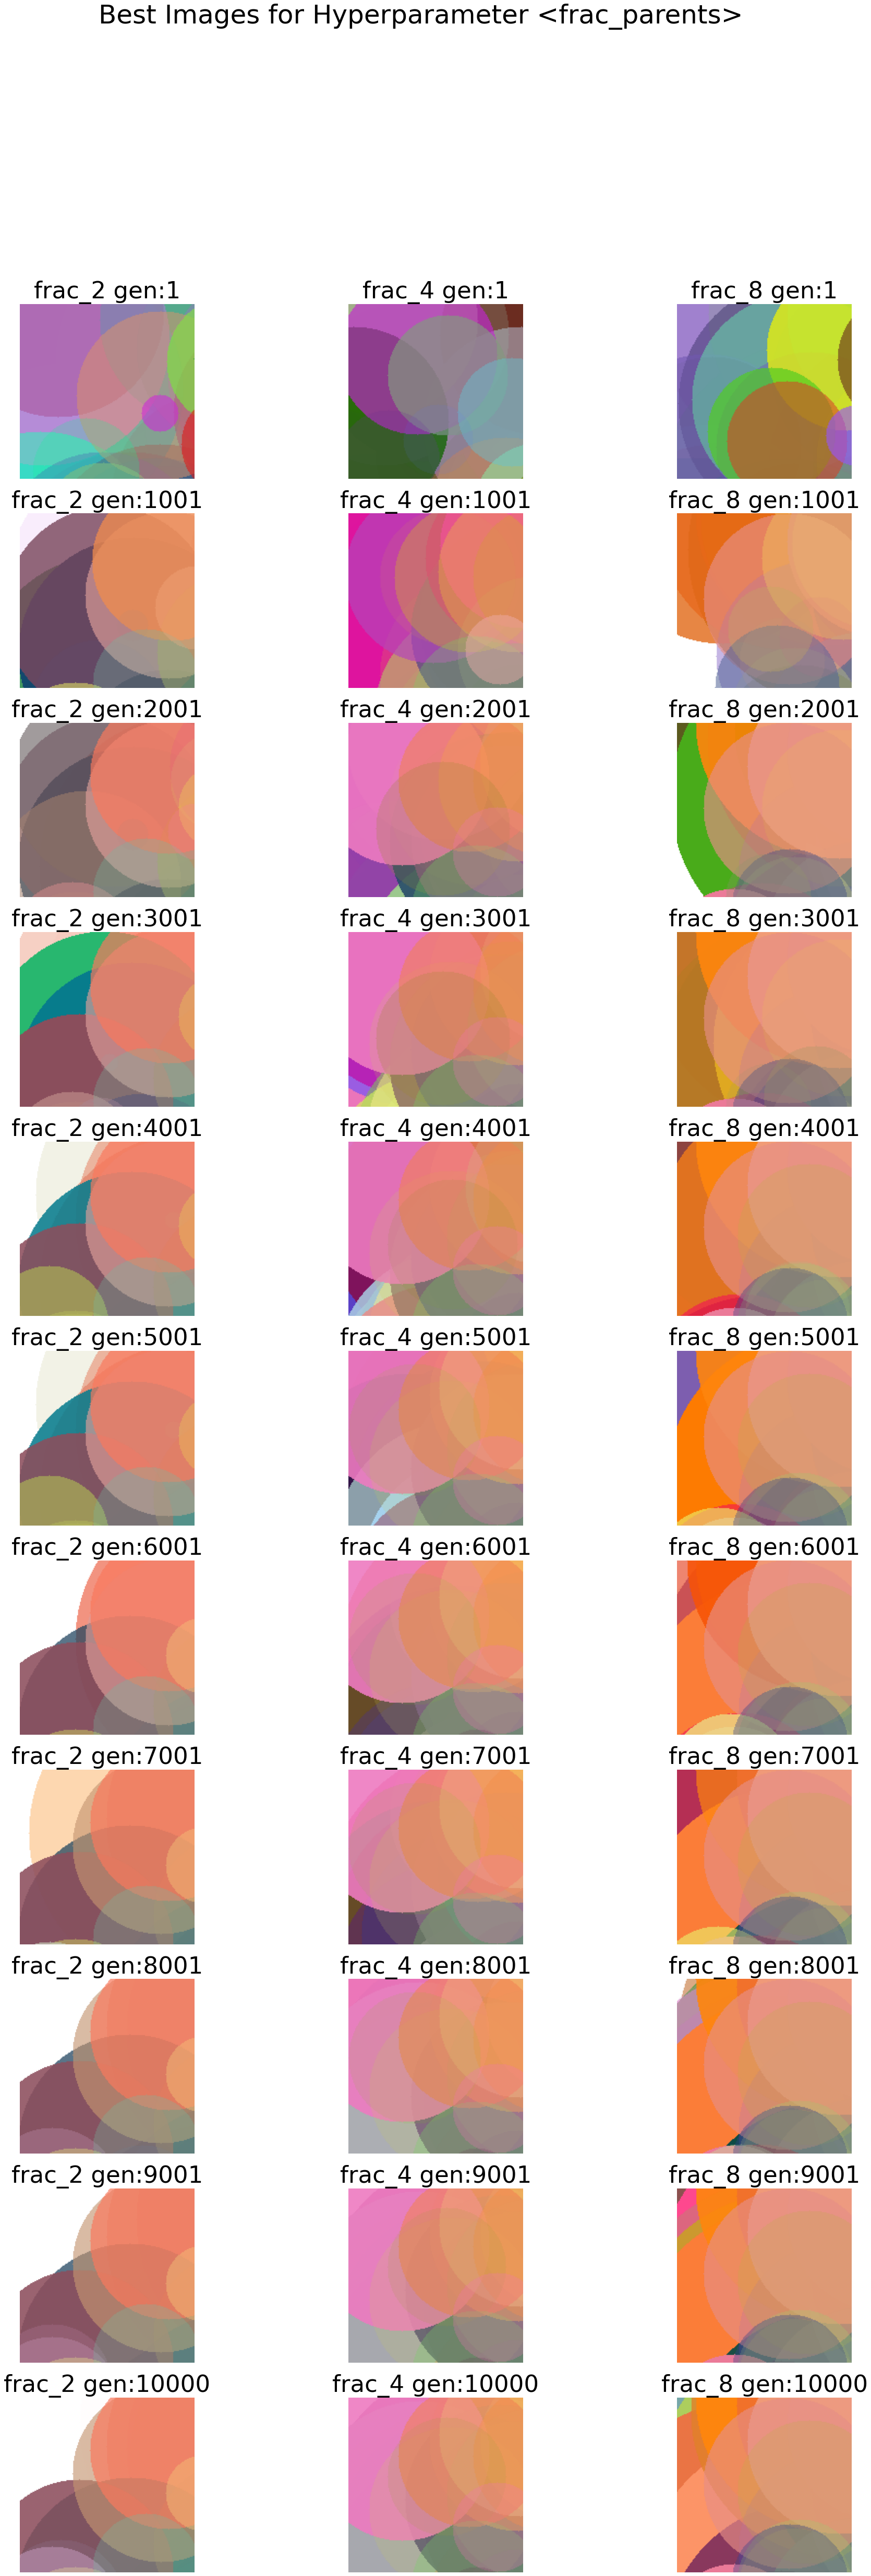

In [ ]:
# get frac_parents experimetal results from saved files and visualize them
frac_parents_images = get_all_images(["frac_parents/frac_2", "frac_parents/frac_4", "frac_parents/frac_8"])
plot_images(frac_parents_images, "frac_parents", save_dir=SAVE_DIR + 'frac_parents_images')
plot_fitnesses(frac_parents_images, "frac_parents", save_dir=SAVE_DIR + 'frac_parents_fitness')


In [ ]:
# get mutation_prob experimetal results from saved files and visualize them
mutation_prob_images = get_all_images(["mutation_prob/prob_1", "mutation_prob/prob_5", "mutation_prob/prob_8"])
plot_images(mutation_prob_images, "mutation_prob", save_dir=SAVE_DIR + 'mutation_prob_images')
plot_fitnesses(mutation_prob_images, "mutation_prob", save_dir=SAVE_DIR + 'mutation_prob_fitness')


In [ ]:
# get mutation_type experimetal results from saved files and visualize them
mutation_type_images = get_all_images(["mutation_type/unguided"])
plot_images(mutation_type_images, "mutation_type", save_dir=SAVE_DIR + 'mutation_type_images')
plot_fitnesses(mutation_type_images, "mutation_type", save_dir=SAVE_DIR + 'mutation_type_fitness')

In [ ]:
hyper_params_1 = HyperParameters(20, 50, 5, 0.2, 0.6, 0.2, "guided")
hyper_params_2 = HyperParameters(5 , 50, 5, 0.2, 0.6, 0.2, "guided")
hyper_params_3 = HyperParameters(10, 50, 5, 0.2, 0.6, 0.2, "guided")
hyper_params_4 = HyperParameters(50, 50, 5, 0.2, 0.6, 0.2, "guided")
hyper_params_5 = HyperParameters(75, 50, 5, 0.2, 0.6, 0.2, "guided")

In [ ]:
ea_1 = Population(hyper_params_1, "num_inds/default_inds_20")
ea_1.evolution()

ea_5 = Population(hyper_params_5, "num_inds/inds_75")
ea_5.evolution()

ea_4 = Population(hyper_params_4, "num_inds/inds_50")
ea_4.evolution()

ea_3 = Population(hyper_params_3, "num_inds/inds_10")
ea_3.evolution()

ea_2 = Population(hyper_params_2, "num_inds/inds_5")
ea_2.evolution()

In [ ]:
"""hyper_params_1 = HyperParameters(20, 50, 5, 0.2, 0.6, 0.2, "guided")"""
hyper_params_2 = HyperParameters(20, 10, 5, 0.2, 0.6, 0.2, "guided")
hyper_params_3 = HyperParameters(20, 25, 5, 0.2, 0.6, 0.2, "guided")
hyper_params_4 = HyperParameters(20, 100, 5, 0.2, 0.6, 0.2, "guided")
hyper_params_5 = HyperParameters(20, 150, 5, 0.2, 0.6, 0.2, "guided")

In [ ]:
"""ea_1 = Population(hyper_params_1, "num_genes/default_genes_50")
ea_1.evolution()"""

ea_5 = Population(hyper_params_5, "num_genes/genes_150")
ea_5.evolution()

ea_2 = Population(hyper_params_2, "num_genes/genes_10")
ea_2.evolution()

ea_3 = Population(hyper_params_3, "num_genes/genes_25")
ea_3.evolution()

ea_4 = Population(hyper_params_4, "num_genes/genes_100")
ea_4.evolution()


In [ ]:
hyper_params_1 = HyperParameters(20, 50, 5, 0.2, 0.6, 0.2, "guided")
hyper_params_2 = HyperParameters(20, 50, 2, 0.2, 0.6, 0.2, "guided")
hyper_params_3 = HyperParameters(20, 50, 10, 0.2, 0.6, 0.2, "guided")
hyper_params_4 = HyperParameters(20, 50, 20, 0.2, 0.6, 0.2, "guided")

In [ ]:
"""ea_1 = Population(hyper_params_1, "tm_size/default_size_5")
ea_1.evolution()"""

ea_2 = Population(hyper_params_2, "tm_size/size_2")
ea_2.evolution()

ea_3 = Population(hyper_params_3, "tm_size/size_10")
ea_3.evolution()

ea_4 = Population(hyper_params_4, "tm_size/size_20")
ea_4.evolution()

In [ ]:
hyper_params_1 = HyperParameters(20, 50, 5, 0.2, 0.6, 0.2, "guided")
hyper_params_2 = HyperParameters(20, 50, 5, 0.05, 0.6, 0.2, "guided")
hyper_params_3 = HyperParameters(20, 50, 5, 0.4, 0.6, 0.2, "guided")

In [ ]:
"""ea_1 = Population(hyper_params_1, "frac_elites/default_frac_2")
ea_1.evolution()"""

ea_2 = Population(hyper_params_2, "frac_elites/frac_05")
ea_2.evolution()

ea_3 = Population(hyper_params_3, "frac_elites/frac_4")
ea_3.evolution()


In [ ]:
hyper_params_1 = HyperParameters(20, 50, 5, 0.2, 0.6, 0.2, "guided")
hyper_params_2 = HyperParameters(20, 50, 5, 0.2, 0.2, 0.2, "guided")
hyper_params_3 = HyperParameters(20, 50, 5, 0.2, 0.4, 0.2, "guided")
hyper_params_4 = HyperParameters(20, 50, 5, 0.2, 0.8, 0.2, "guided")

In [ ]:
"""ea_1 = Population(hyper_params_1, "frac_parents/default_frac_6")
ea_1.evolution()"""

ea_2 = Population(hyper_params_2, "frac_parents/frac_2")
ea_2.evolution()

ea_3 = Population(hyper_params_3, "frac_parents/frac_4")
ea_3.evolution()

ea_4 = Population(hyper_params_4, "frac_parents/frac_8")
ea_4.evolution()

In [ ]:
"""hyper_params_1 = HyperParameters(20, 50, 5, 0.2, 0.6, 0.2, "guided")"""
hyper_params_2 = HyperParameters(20, 50, 5, 0.2, 0.6, 0.1, "guided")
hyper_params_3 = HyperParameters(20, 50, 5, 0.2, 0.6, 0.5, "guided")
hyper_params_4 = HyperParameters(20, 50, 5, 0.2, 0.6, 0.8, "guided")

In [ ]:
"""ea_1 = Population(hyper_params_1, "mutation_prob/default_prob_2")
ea_1.evolution()"""

ea_2 = Population(hyper_params_2, "mutation_prob/prob_1")
ea_2.evolution()

ea_3 = Population(hyper_params_3, "mutation_prob/prob_5")
ea_3.evolution()

ea_4 = Population(hyper_params_4, "mutation_prob/prob_8")
ea_4.evolution()

In [ ]:
"""hyper_params_1 = HyperParameters(20, 50, 5, 0.2, 0.6, 0.2, "guided")"""
hyper_params_2 = HyperParameters(20, 50, 5, 0.2, 0.6, 0.2, "unguided")

In [ ]:
"""ea_1 = Population(hyper_params_1, "mutation_type/default_guided")
ea_1.evolution()"""

ea_2 = Population(hyper_params_2, "mutation_type/unguided")
ea_2.evolution()

In [16]:
### DISCUSSION PART ###
# FIRST SUGGESTION: Scheduled learning
"""•	Generations 0-300: <mutation_prob> = 0.8
•	Generations 300-1000: <mutation_prob> = 0.5
•	Generations 1000-2000: <mutation_prob> = 0.2
•	Generations 2000-10000: <mutation_prob> = 0.1
Also:
•	Generations 0-200: <mutation_type> = “unguided”
•	Generations 200-10000: <mutation_type> = “guided”"""

# we need to change the evaluation function of Population class. 

class Population_v2:
  def __init__(self, hyper_params, name, iteration=10000):
    self.params = hyper_params
    self.inds = []
    self.name = name
    self.iteration = iteration
    self.best_inds = []

  def sortIndividuals(self, pop):
    return sorted(pop, key=lambda item: item.fitness, reverse=True)

  def initPopulation(self):
    self.inds = []
    for i in range(self.params.num_inds):
      ind = Individual(i+1)
      ind.initIndividual(self.params.num_genes)
      self.inds.append(ind)

  def evaluate(self):
    for ind in self.inds:
      ind.evaluate()

  def select(self):
    num_elites = int(self.params.frac_elites * self.params.num_inds)
    num_parents = int(self.params.frac_parents * self.params.num_inds)
    if num_parents % 2 == 1:
      num_parents = num_parents + 1

    self.inds = self.sortIndividuals(self.inds)
    elite_inds = self.inds[:num_elites]
    other_inds = self.inds[num_elites:]

    parent_inds = []
    for i in range(num_parents):
      max     = sum([ind.fitness/100000 for ind in other_inds])
      pick    = rnd.uniform(0, max)
      current = 0
      for idx in range(len(other_inds)):
          current += other_inds[idx].fitness/100000
          if current < pick:
              parent_inds.append(other_inds.pop(idx))
              break
      """for i in range(num_parents):
        best_idx = rnd.randrange(len(other_inds))
        for i in range(self.params.tm_size):
          idx = rnd.randrange(len(other_inds))
          if other_inds[idx].fitness > other_inds[best_idx].fitness:
            best_idx = idx
        parent_inds.append(other_inds.pop(best_idx))"""
    return (elite_inds, parent_inds, other_inds)

  def crossover(self, parents):
    children = []
    num_parents = int(self.params.frac_parents * self.params.num_inds)
    if num_parents % 2 == 1:
      num_parents = num_parents + 1
    for i in range(0, num_parents, 2):
      chromosome_chld_1 = []
      chromosome_chld_2 = []
      r = np.random.randint(2, size=self.params.num_genes)
      for j in range(self.params.num_genes):
        if r[j] == 0:
          chromosome_chld_1.append(copy.deepcopy(parents[ i ].chromosome[j]))
          chromosome_chld_2.append(copy.deepcopy(parents[i+1].chromosome[j]))
        else:
          chromosome_chld_1.append(copy.deepcopy(parents[i+1].chromosome[j]))
          chromosome_chld_2.append(copy.deepcopy(parents[ i ].chromosome[j]))
      child1 = Individual(chromosome=chromosome_chld_1)
      child2 = Individual(chromosome=chromosome_chld_2)
      child1.evaluate()
      child2.evaluate()
      pop = self.sortIndividuals([parents[i], parents[i+1], child1, child2])
      children.append(pop[0])
      children.append(pop[1])
    return children

  def mutation(self, pop, iteration):
    for ind in pop:
      if rnd.random() < self.params.mutation_prob:
        ind.mutate(self.params.mutation_type, self.params.mutation_prob)

  def mutation_v2(self, pop, iteration):
    if iteration < 1000:
      self.mutation(pop, iteration)
    else:
      for ind in pop:
        if rnd.random() < self.params.mutation_prob:
          ind_copy = copy.deepcopy(ind)
          for i in range(5):
            ind_copy.mutate(self.params.mutation_type, self.params.mutation_prob)
            ind_copy.evaluate()
            if ind_copy.fitness > ind.fitness:
              ind = copy.deepcopy(ind_copy)
              break
          ind = copy.deepcopy(ind_copy)

  def evolution(self, i=0, mutation_fun='v1'):
    """•	Generations 0-300: <mutation_prob> = 0.8
      •	Generations 300-1000: <mutation_prob> = 0.5
      •	Generations 1000-2000: <mutation_prob> = 0.2
      •	Generations 2000-10000: <mutation_prob> = 0.1
      Also:
      •	Generations 0-200: <mutation_type> = “unguided”
      •	Generations 200-10000: <mutation_type> = “guided”"""
    """self.params.mutation_prob = 0.8
    self.params.mutation_type = "unguided"""
    # Initialize population with <num_inds> individuals each having <num_genes> genes
    """self.initPopulation()"""
    # While not all generations (<num_generations>) are computed:
    for i in range(i, self.iteration):
      # schedule settings
      if i == 200:
        self.params.mutation_type = "guided"
      elif i == 300:
        self.params.mutation_prob = 0.5
      elif i == 1000:
        self.params.mutation_prob = 0.2
      elif i == 2000:
        self.params.mutation_prob = 0.1
      # Evaluate all the individuals
      self.evaluate()
      # Select individuals
      (elits, parents, others) = self.select()
      # Do crossover on some individuals
      children = self.crossover(parents)
      # Mutate some individuals
      if mutation_fun == 'v1':
        self.mutation(others+ children, i)
      else:
        self.mutation_v2(others+ children, i)
      self.inds = elits + others + children
      if i%100 == 0:
        print("iteration: ",i)
      if i%500 == 499:
        for ind in self.inds:
          cv2_imshow(ind.getImage())
          print("fitness: ", ind.fitness)
      if i%1000 == 0:
        j=0
        self.best_inds.append(self.sortIndividuals(self.inds)[0])
        for ind in self.inds:
          name = self.name + '_iteration_' + str(i+1)
          save_obj(self, name)
          name = '/content/drive/MyDrive/EE449/HW2/'+self.name + '_iteration_'
        cv2.imwrite(name+str(i+1)+'_ind_'+str(j)+'.png', self.inds[0].getImage())
        j=j+1
    self.evaluate()
    self.best_inds.append(self.sortIndividuals(self.inds)[0])
    name = self.name + '_iteration_10000'
    save_obj(self, name)
    name = '/content/drive/MyDrive/EE449/HW2/' + name
    cv2.imwrite(name+'.png', self.inds[0].getImage())

  def printPopulation(self):
      for ind in self.inds:
        ind.printIndividual()


In [ ]:
hyper_params_1 = HyperParameters(20, 50, 5, 0.2, 0.6, 0.2, "guided")
ea_1 = Population_v2(hyper_params_1, "discussion/scheduled_mutation")
ea_1.evolution()

Output hidden; open in https://colab.research.google.com to view.

iteration:  0
iteration:  100
iteration:  200
iteration:  300
iteration:  400


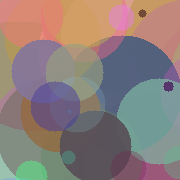

fitness:  -128974275


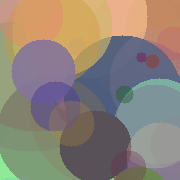

fitness:  -131496368


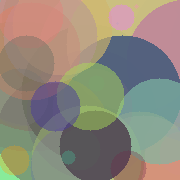

fitness:  -131903518


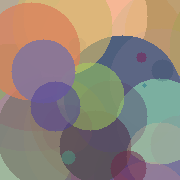

fitness:  -131988978


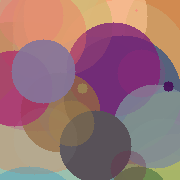

fitness:  -174954646


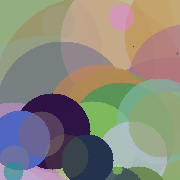

fitness:  -217517837


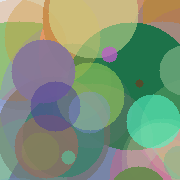

fitness:  -225541724


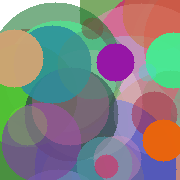

fitness:  -404590044


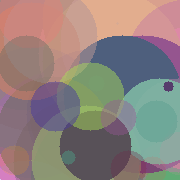

fitness:  -132928233


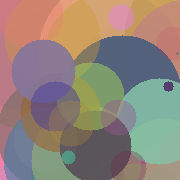

fitness:  -135983015


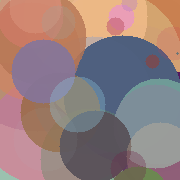

fitness:  -141839574


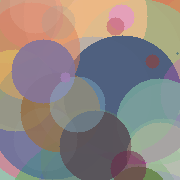

fitness:  -149477485


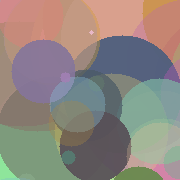

fitness:  -134864552


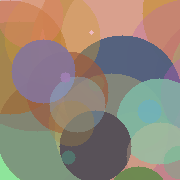

fitness:  -141283547


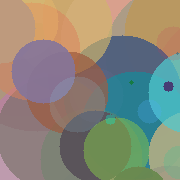

fitness:  -150733951


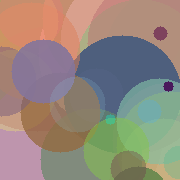

fitness:  -156685165


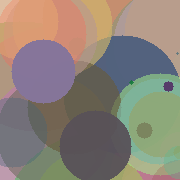

fitness:  -149736618


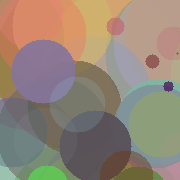

fitness:  -165490192


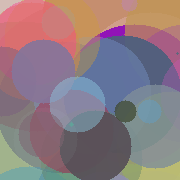

fitness:  -149537459


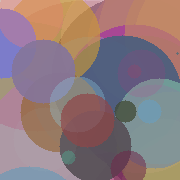

fitness:  -164923028
iteration:  500
iteration:  600
iteration:  700
iteration:  800
iteration:  900


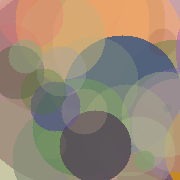

fitness:  -111955040


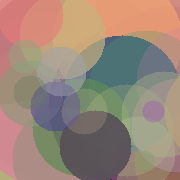

fitness:  -112795067


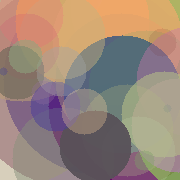

fitness:  -112800229


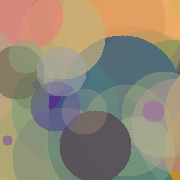

fitness:  -112884612


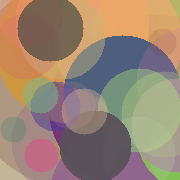

fitness:  -164409643


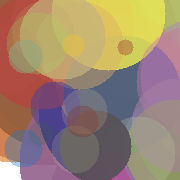

fitness:  -204251085


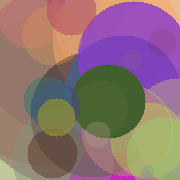

fitness:  -273159662


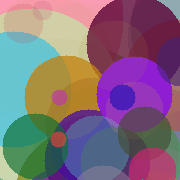

fitness:  -448065024


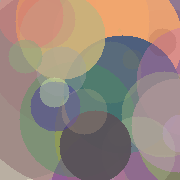

fitness:  -117986793


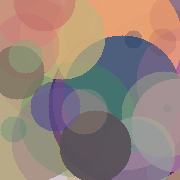

fitness:  -119063537


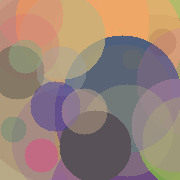

fitness:  -118062860


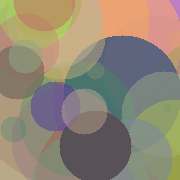

fitness:  -127135009


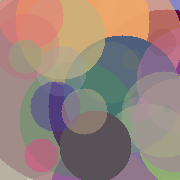

fitness:  -117146605


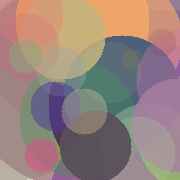

fitness:  -122396665


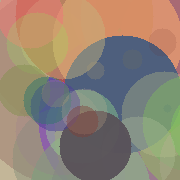

fitness:  -126757773


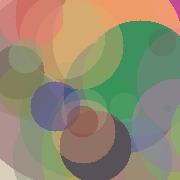

fitness:  -127534313


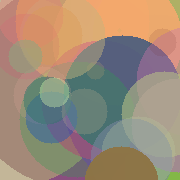

fitness:  -133533191


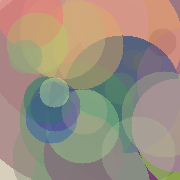

fitness:  -138607460


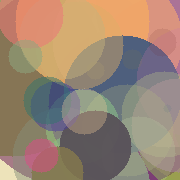

fitness:  -127575810


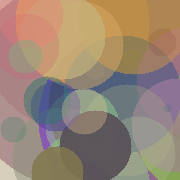

fitness:  -143506243
iteration:  1000
iteration:  1100
iteration:  1200
iteration:  1300
iteration:  1400


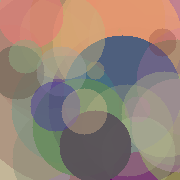

fitness:  -104308052


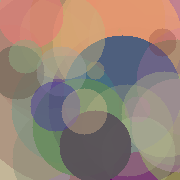

fitness:  -104308052


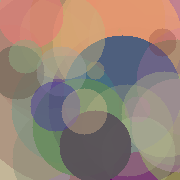

fitness:  -104308052


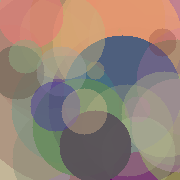

fitness:  -104308052


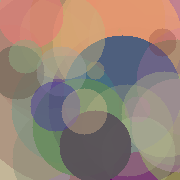

fitness:  -104308052


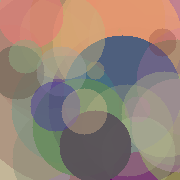

fitness:  -104308052


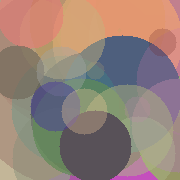

fitness:  -115123113


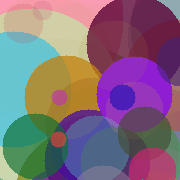

fitness:  -448065024


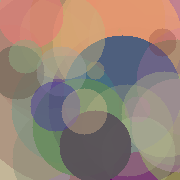

fitness:  -104308052


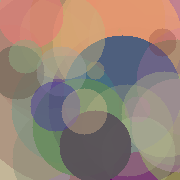

fitness:  -104308052


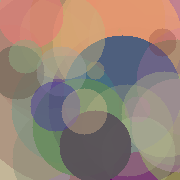

fitness:  -104308052


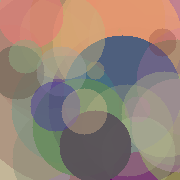

fitness:  -104308052


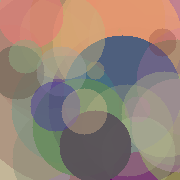

fitness:  -104308052


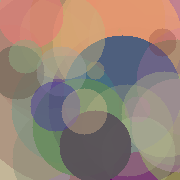

fitness:  -104308052


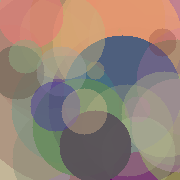

fitness:  -104308052


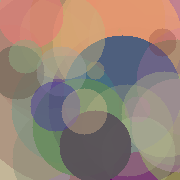

fitness:  -104308052


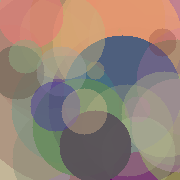

fitness:  -104308052


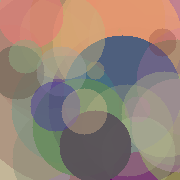

fitness:  -104308052


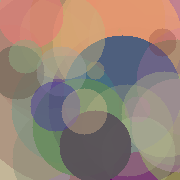

fitness:  -104308052


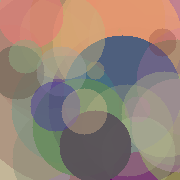

fitness:  -104308052
iteration:  1500
iteration:  1600
iteration:  1700
iteration:  1800
iteration:  1900


KeyboardInterrupt: ignored

In [ ]:
# SECOND SUGGESTION: Use the best parameters

ea_2 = Population_v2(hyper_params_1, "discussion/better_mutation")
ea_2.evolution(mutation_fun='v2')

In [ ]:
# SECOND SUGGESTION: Use the best parameters
"""
•	<num_inds>=75
•	<num_genes>=150
•	<tm_size>=2
•	<frac_elites>=0.05
•	<frac_parents>=0.8
•	scheduled mutation,

"""
hyper_params_3 = HyperParameters(50, 1000, 2, 0.05, 0.8, 0.2, "guided")
ea = Population(hyper_params_3, "discussion/best")
ea.evaluate()

In [ ]:

ea = Population_v2(hyper_params_3, "discussion/best_parameters_img3")
ea.params = ea_3.params
ea.inds = ea_3.inds
ea.iteration = ea_3.iteration
ea.best_inds = ea_3.best_inds
ea.evolution(3001)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ea_3 = Population_v2(hyper_params_3, "discussion/best_parameters_img3")